# ECON autoencoder loss analysis
This notebook aims to show the effect of the hyperparameters on the ECON model which could be hide to the user due to the approximation of the EMD metrics.

In [1]:
%reload_ext autoreload
%autoreload 2

# from common.metrics.gradient import Gradient
import torch
from torch.utils.data import DataLoader
import torchinfo
import numpy as np
import pandas as pd
import pytorch_lightning as pl 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
from q_autoencoder import AutoEncoder
from autoencoder_datamodule import AutoEncoderDataModule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA
from neural_efficiency import NeuralEfficiency


# import modules from common benchmarks
module_path = os.path.abspath(os.path.join('../../workspace/common/benchmarks/')) # or the path to your source code
sys.path.insert(0, module_path)
from noisy_dataset import NoisyDataset



DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

/opt/conda/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Utility methods

In [2]:
def get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size, num_tests=3):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    EMDs = []
    min_emd = 1000
    min_emd_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'ECON_{precision}b/{size}/{size}_emd_{i}.txt'
        try:
            emd_file = open(file_path)
            emd_text = emd_file.read()
            emd = ast.literal_eval(emd_text)
            emd = emd[0]['AVG_EMD']
            EMDs.append(emd)
            if min_emd >= emd:
                min_emd = emd
                min_emd_index = i
            emd_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(EMDs) == 0:
        # warnings.warn(f"Attention: There is no EMD value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}")
        #TODO: I may compute if the model is there
        return
    
    return mean(EMDs), min_emd_index


def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Reds',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, cmap=cmap, annot=show_value, fmt=".2f", vmin=min_max[0], vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()


def load_model(batch_size, learning_rate, precision, size):
    '''
    Method used to get the model and the relative EMD value
    '''
    emd, idx = get_model_index_and_relative_EMD(batch_size, learning_rate, precision, size)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/net_{idx}_best.pkl'
    
    # load the model
    model = AutoEncoder(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
        econ_type=size
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((1, 1, 8, 8)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, emd


def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = AutoEncoderDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # checek if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module

def get_noise_dataloader(batch_size, dataloader, num_workers=12, percentage=5, noise_type='random'):
    noisy_dataset = NoisyDataset(dataloader, 
                                 percentage, 
                                 noise_type)
    return DataLoader(noisy_dataset, 
                      shuffle=False,
                      num_workers=num_workers,
                      batch_size=batch_size)



# EMD distance results

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
size = 'baseline'

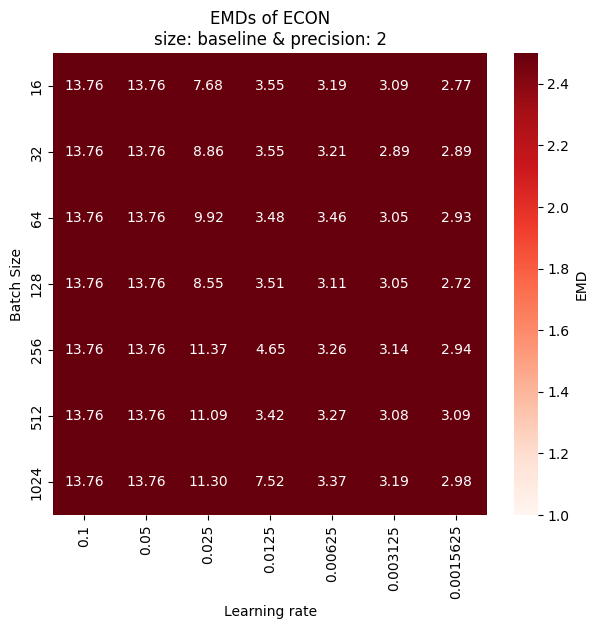

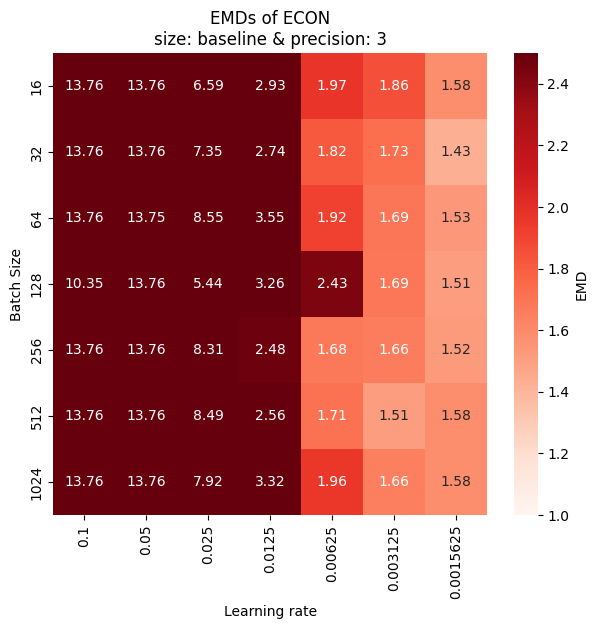

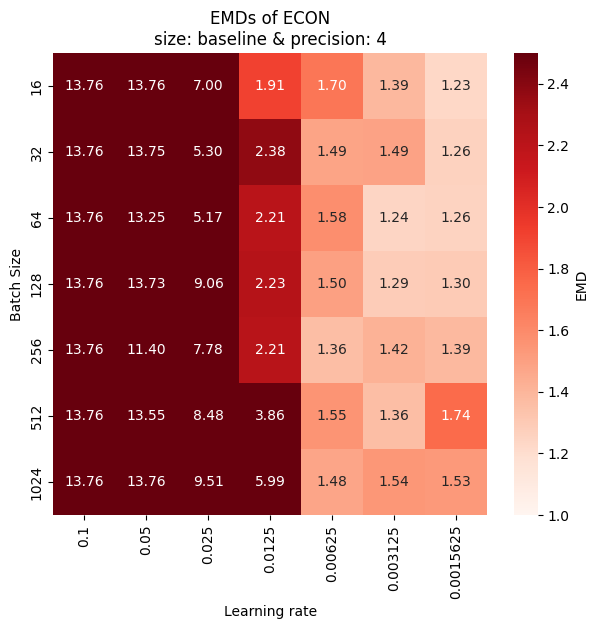

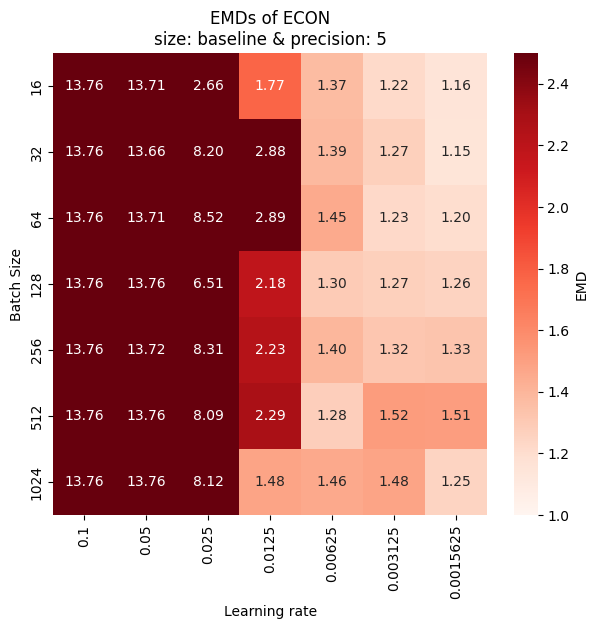

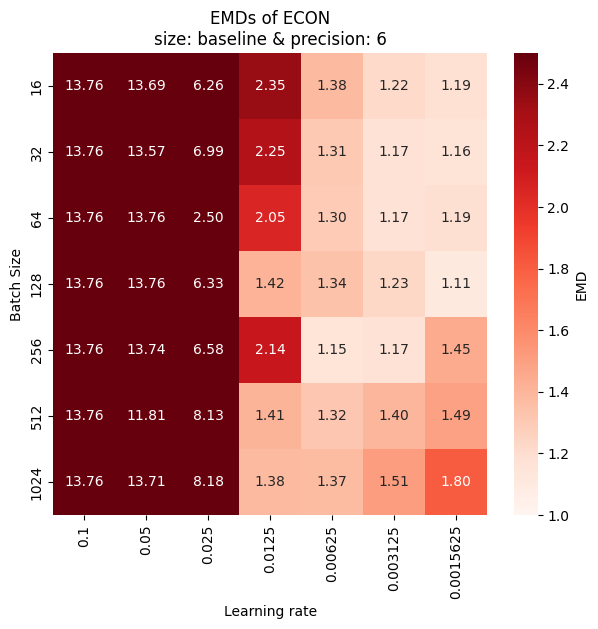

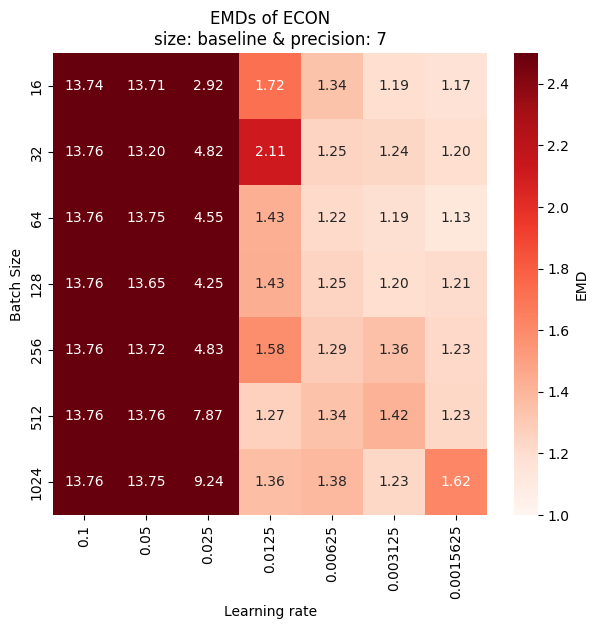

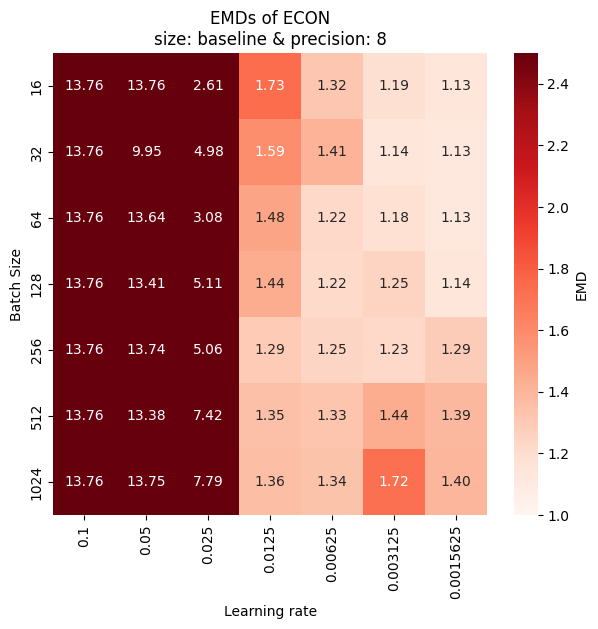

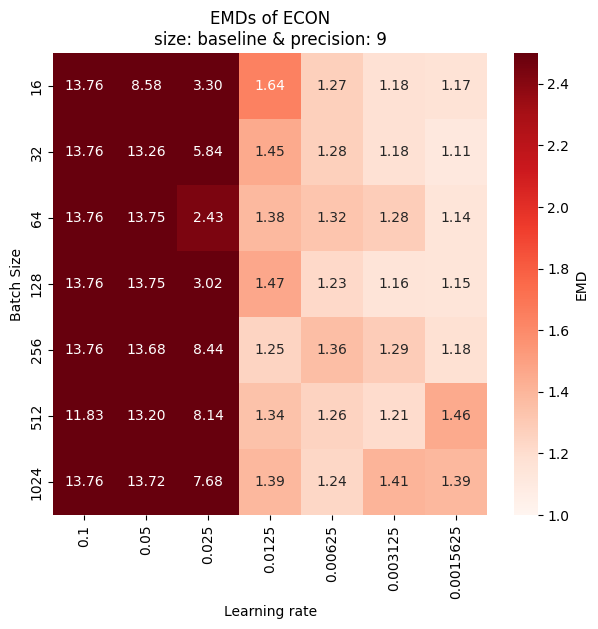

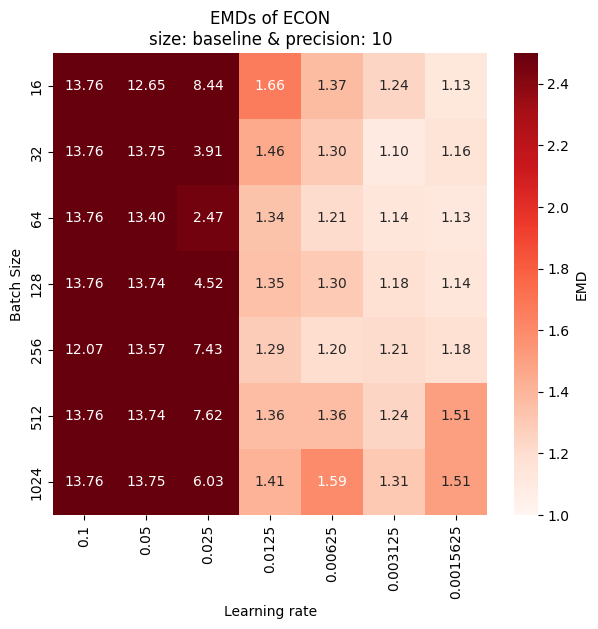

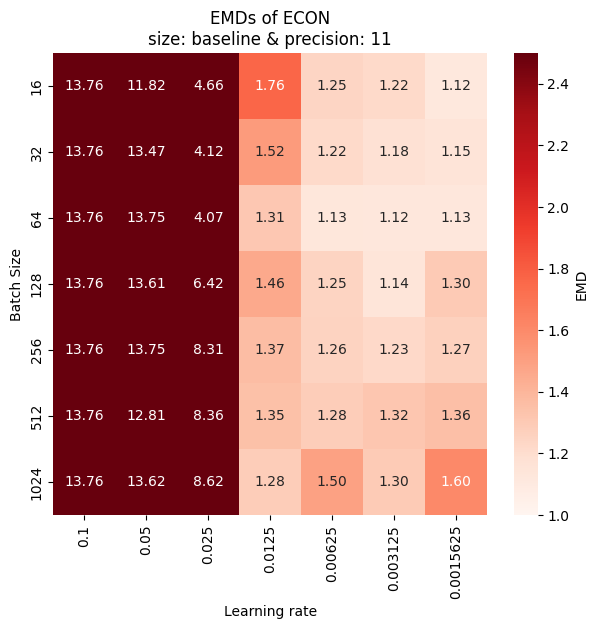

In [4]:
%matplotlib inline

#TODO: 3d heatmap and add noise

# plotting a heat map per layer
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            
            
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
    


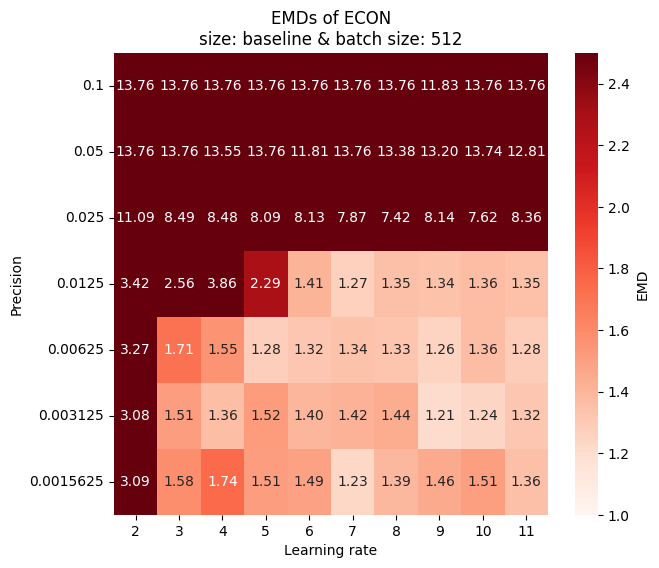

In [5]:
%matplotlib inline

batch_size = 512
EMD_matrix = np.zeros((len(learning_rates), len(precisions)))
# EMD_matrix = np.zeros((len(precisions), len(learning_rates)))
# plotting a heat map per layer
for y, p in enumerate(precisions):
    for x, lr in enumerate(learning_rates):
        mean_EMD, _ = get_model_index_and_relative_EMD(batch_size, lr, p, size)
        EMD_matrix[x, y] = mean_EMD
            
            
EMD_matrix = pd.DataFrame(EMD_matrix, 
                        index=learning_rates, 
                        columns=precisions)

plot_2d_heatmap(EMD_matrix, 
                f'EMDs of ECON\nsize: {size} & batch size: {batch_size}', 
                (1, 2.5),
                'Learning rate',
                'Precision',
                'EMD')

We want to focus only with models with good performances so we cut out from the analysis the high learning rates.

In [6]:
learning_rates = [0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
# plotting a heat map per layer
top_models_count = 2
best_models = {}
worst_models = {}
emd_distribution = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_EMD, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = mean_EMD
            emd_distribution.append({
                'precision': p, 
                'EMD': mean_EMD,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })

    # store best and worst models
    sorted_indices = np.argsort(EMD_matrix.flatten(), axis=None)
    
    best_models[p] = []
    worst_models[p] = []
    
    # store the top among best and worst models
    for i in range(top_models_count):
        index = sorted_indices[i]
        best_model_coords = np.unravel_index(index, EMD_matrix.shape)
        
        index = sorted_indices[-(i + 1)]
        worst_model_coords = np.unravel_index(index, EMD_matrix.shape)
        
        best_models[p].append({
            'model': best_model_coords,
            'EMD': EMD_matrix[best_model_coords]
        })
        
        worst_models[p].append({
            'model': worst_model_coords,
            'EMD': EMD_matrix[worst_model_coords]
        })
        
emd_distribution_df = pd.DataFrame(emd_distribution)

In [7]:
emd_distribution_df = emd_distribution_df.sort_values(by='EMD', ascending=True)
emd_distribution_df.head(10)

precision       EMD batch_size learning_rate
288         10  1.104643         32      0.003125
159          6  1.105781        128     0.0015625
254          9  1.114145         32     0.0015625
319         11  1.120972         16     0.0015625
328         11  1.123161         64      0.003125
294         10  1.126236         64     0.0015625
219          8  1.127017         32     0.0015625
329         11  1.127617         64     0.0015625
224          8  1.127975         64     0.0015625
189          7  1.132471         64     0.0015625

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

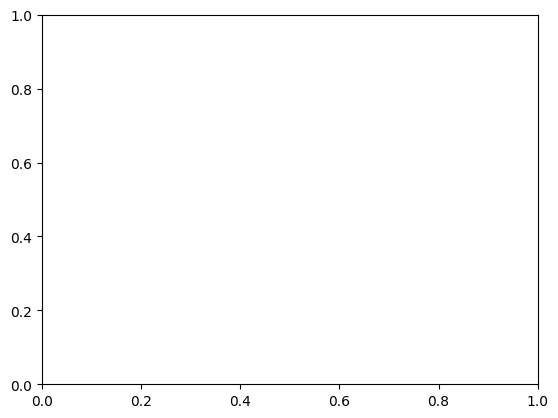

In [8]:
top_5_df = emd_distribution_df.loc[
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.learning_rate == '0.003125') |
    (emd_distribution_df.batch_size == '128') & (emd_distribution_df.learning_rate == '0.0015625') |
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.learning_rate == '0.0015625') |
    (emd_distribution_df.batch_size == '16') & (emd_distribution_df.learning_rate == '0.0015625') |
    (emd_distribution_df.batch_size == '64') & (emd_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='EMD', hue=hue)
plt.title("EMD of the best models at different precisions")

Text(0.5, 1.0, 'EMD of the best models at different leraning rates')

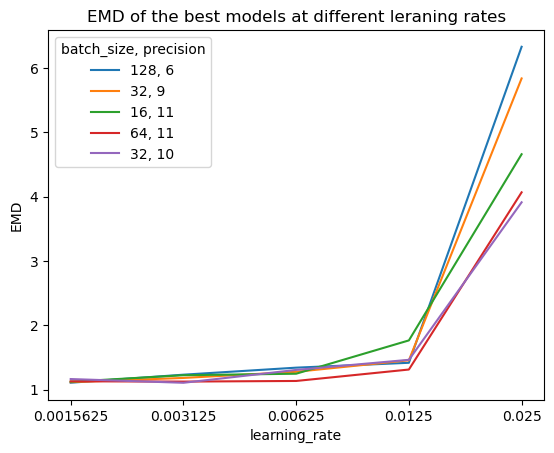

In [ ]:
top_5_df = emd_distribution_df.loc[
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.precision == 10) |
    (emd_distribution_df.batch_size == '128') & (emd_distribution_df.precision == 6) |
    (emd_distribution_df.batch_size == '32') & (emd_distribution_df.precision == 9) |
    (emd_distribution_df.batch_size == '16') & (emd_distribution_df.precision == 11) |
    (emd_distribution_df.batch_size == '64') & (emd_distribution_df.precision == 11)
    ]

top_5_df = top_5_df.sort_values(by='learning_rate', ascending=True)

hue = top_5_df[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_5_df, x='learning_rate', y='EMD', hue=hue)
plt.title("EMD of the best models at different leraning rates")

Distribution of the EMD among the different precisions.

<AxesSubplot:xlabel='precision', ylabel='EMD'>

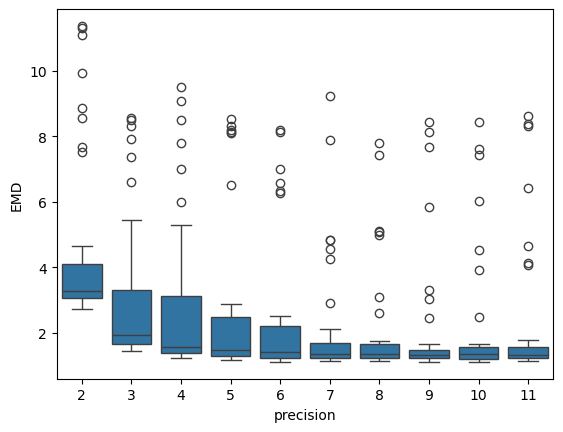

In [ ]:
sns.boxplot(data=emd_distribution_df, x='precision', y='EMD')

Let's discard the precision 2 due to high EMD

## Scientific Benchmark
TODO: box plot for each noise percentage and and number of bit flipped (waiting results)

In [9]:
precisions = [3, 4, 5, 6, 7, 8, 9, 10, 11]
noise_type = 'gaussian'

In [16]:
def get_emd_with_noise(batch_size, learning_rate, precision, size, noise_type, percentage):
    '''
    Return the EMD achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'ECON_{precision}b/{size}/emd_{noise_type}_{percentage}.txt'
    noise_emd = -1
    try:
        emd_file = open(file_path)
        emd_text = emd_file.read()
        if not emd_text.startswith('['):
            noise_emd = float(emd_text)
        else:
            emd = ast.literal_eval(emd_text)
            noise_emd = emd[0]['AVG_EMD']
        emd_file.close()
    except Exception as e:
        warnings.warn("Warning: " + file_path + " not found!")
        return -1
    return noise_emd

def get_emd_with_bitflip(batch_size, learning_rate, precision, size, number_bit):
    '''
    Return the EMD achieved by the Model with a certain number of bit flipped
    '''
    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'ECON_{precision}b/{size}/{size}_emd_bitflip_{number_bit}.txt'
    noise_emd = -1
    try:
        emd_file = open(file_path)
        emd_text = emd_file.read()
        emd = ast.literal_eval(emd_text)
        noise_emd = emd[0]['AVG_EMD']
        emd_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return -1
    return noise_emd

### Bit flip Test

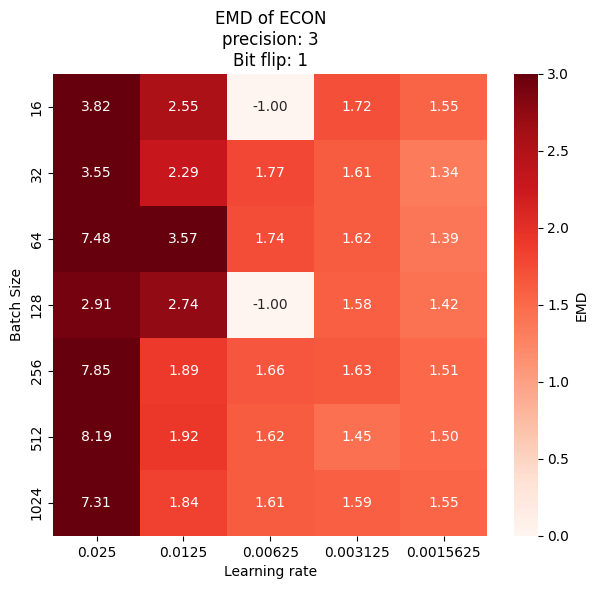

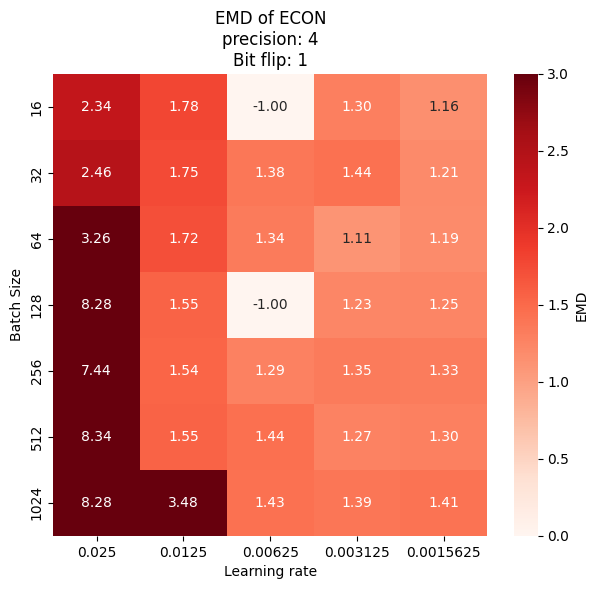

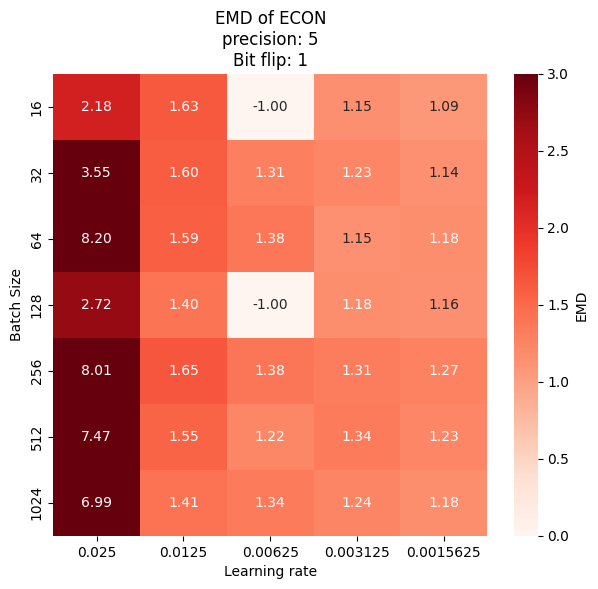

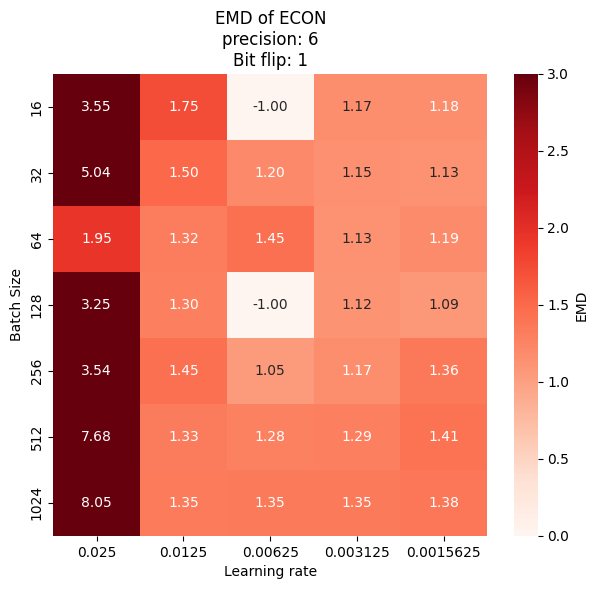

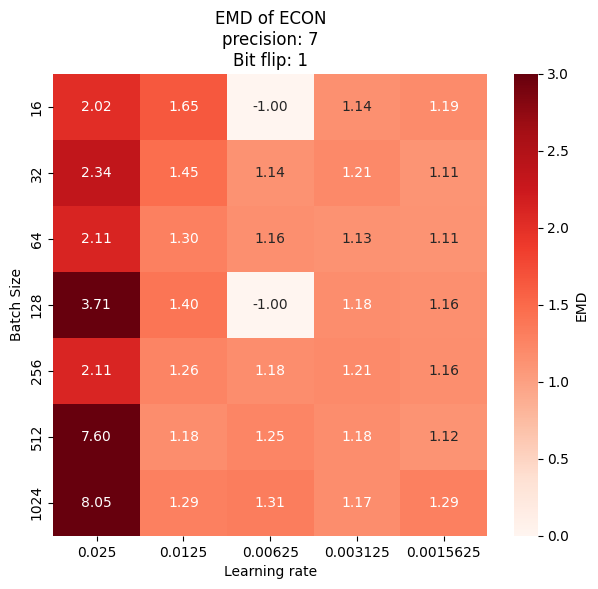

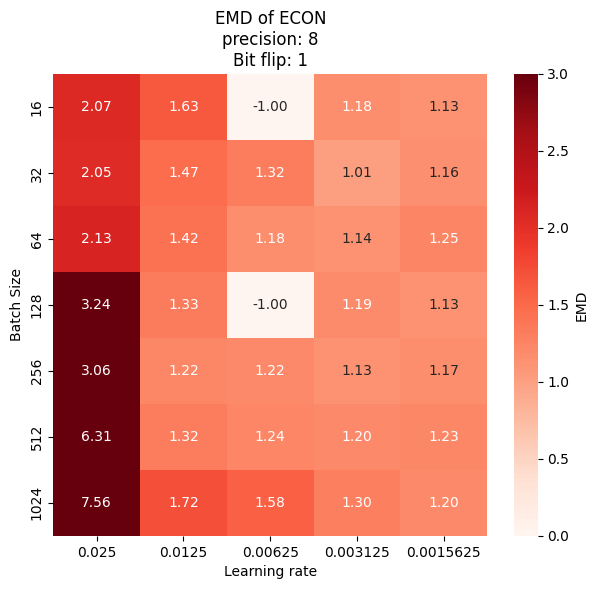

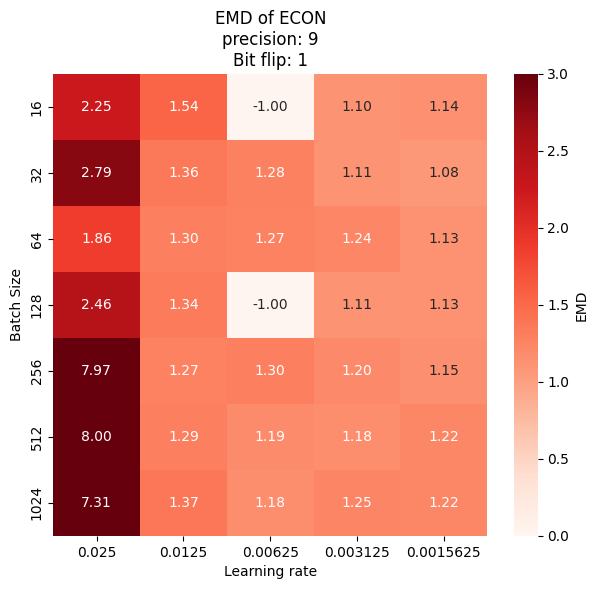

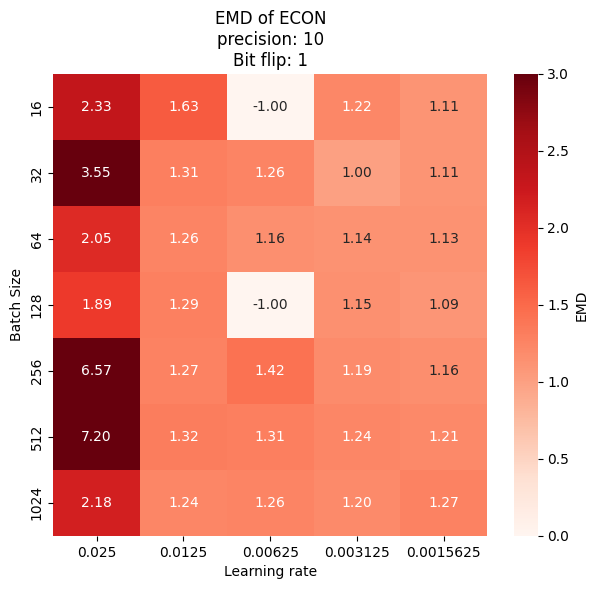

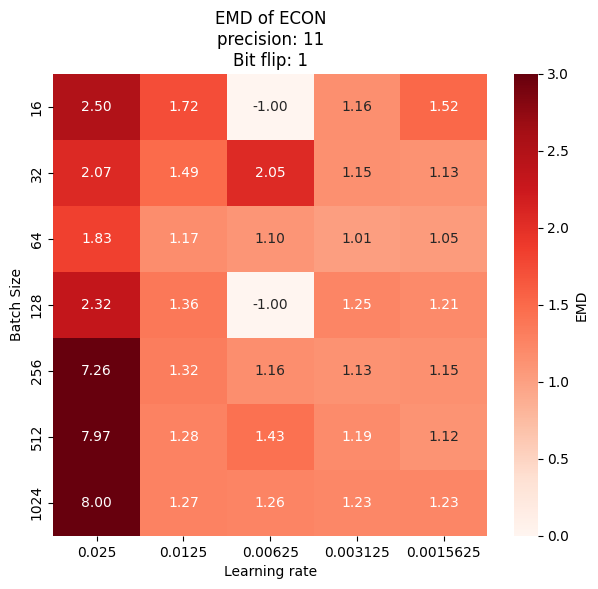

In [11]:
emd_distribution = []
for p in precisions:
    emd_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            bitflip_emd_1 = get_emd_with_bitflip(bs, lr, p, size, 1)
            bitflip_emd_2 = get_emd_with_bitflip(bs, lr, p, size, 2)
            bitflip_emd_3 = get_emd_with_bitflip(bs, lr, p, size, 3)
            bitflip_emd_4 = get_emd_with_bitflip(bs, lr, p, size, 4)
            original_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
                        
            emd_matrix[x, y] = bitflip_emd_1
            
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': 0
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_1,
                'type': '1 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_1) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_2,
                'type': '2 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_2) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_3,
                'type': '3 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_3) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': bitflip_emd_4,
                'type': '4 bit',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': str(p),
                'loss': (original_emd - bitflip_emd_4) * 100 / original_emd,
                'original_emd': original_emd
            })
            
            
    # heat map of the accuracy with noise as input per precision
    emd_matrix = pd.DataFrame(emd_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(emd_matrix, 
                    f'EMD of ECON\nprecision: {p}\n' \
                    f'Bit flip: 1', 
                    (0, 3),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
        
emd_distribution_df = pd.DataFrame(emd_distribution)

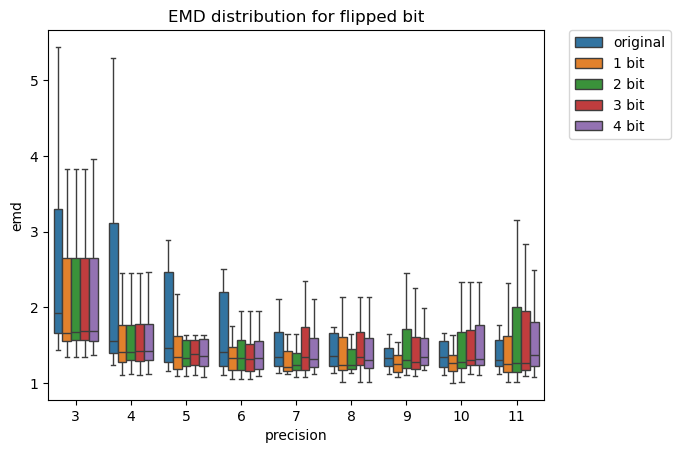

In [14]:
sns.boxplot(data=emd_distribution_df, 
            x='precision', 
            y='emd',
            hue='type',
            showfliers=False)

plt.title(f'EMD distribution for flipped bit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### Noise test

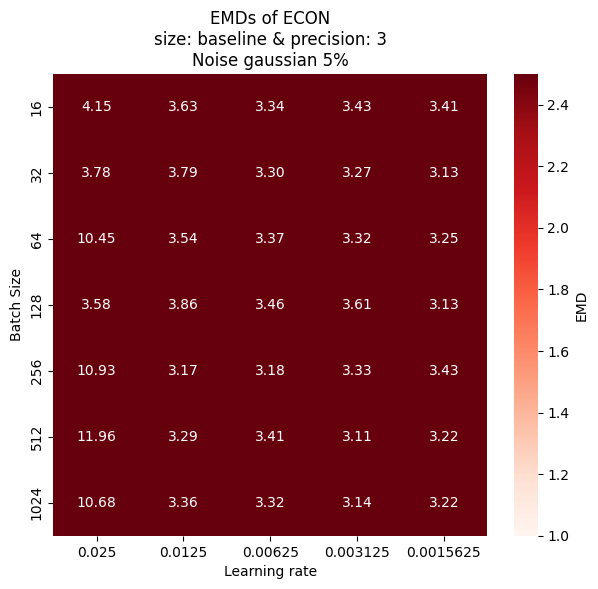

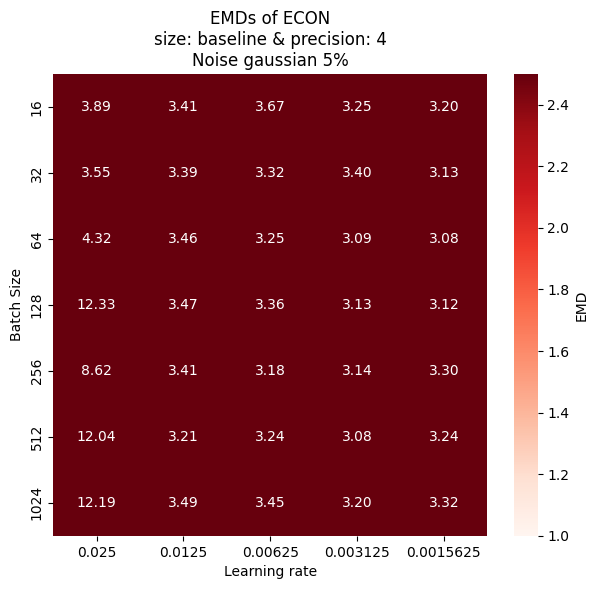

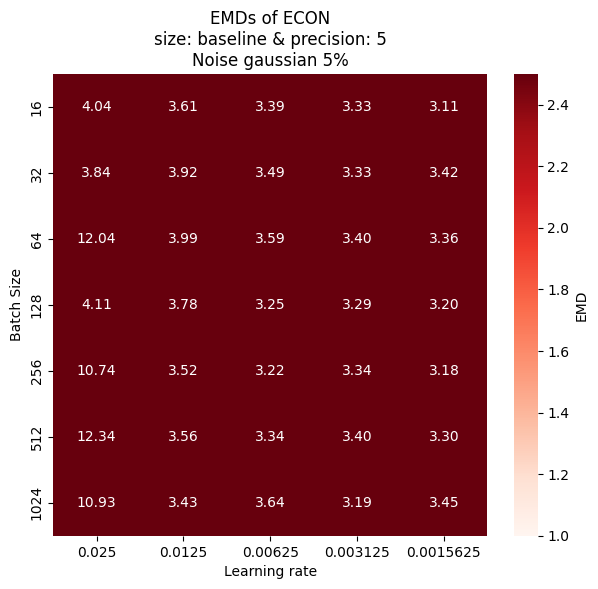

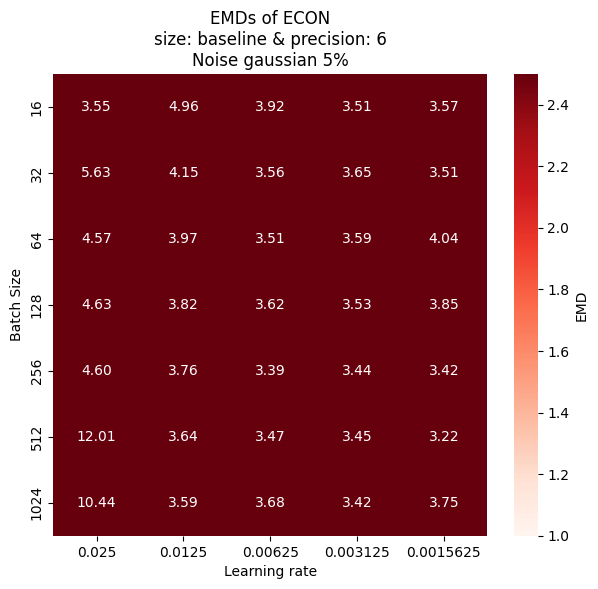

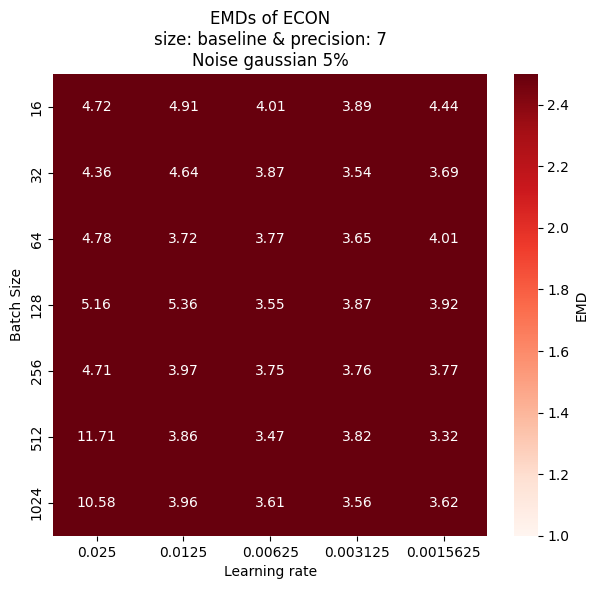

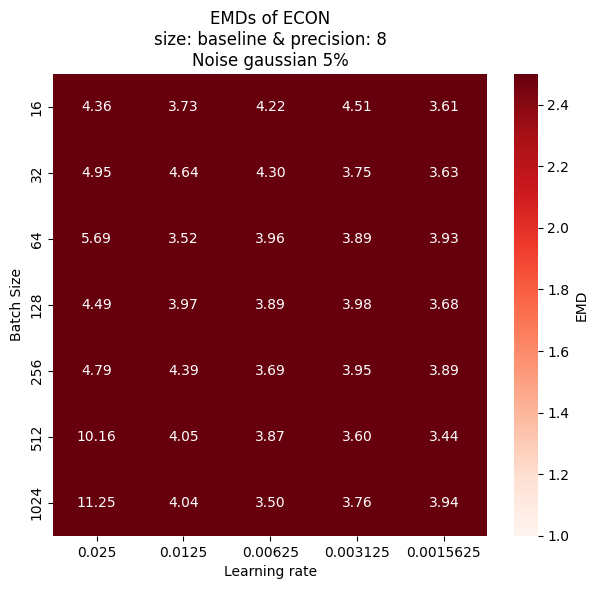

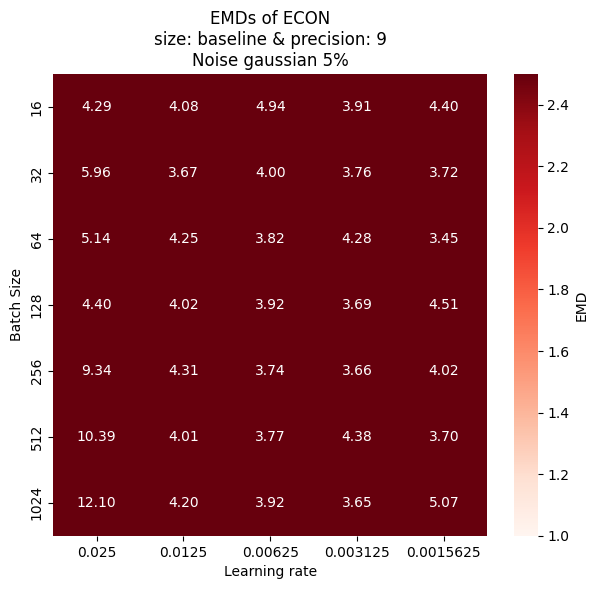

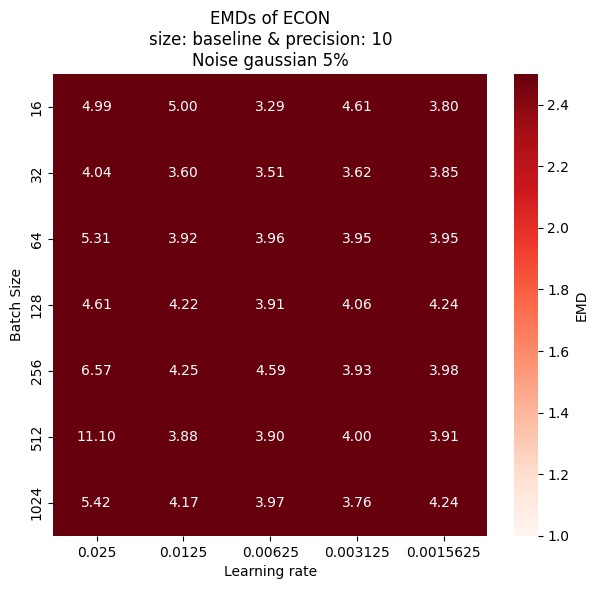

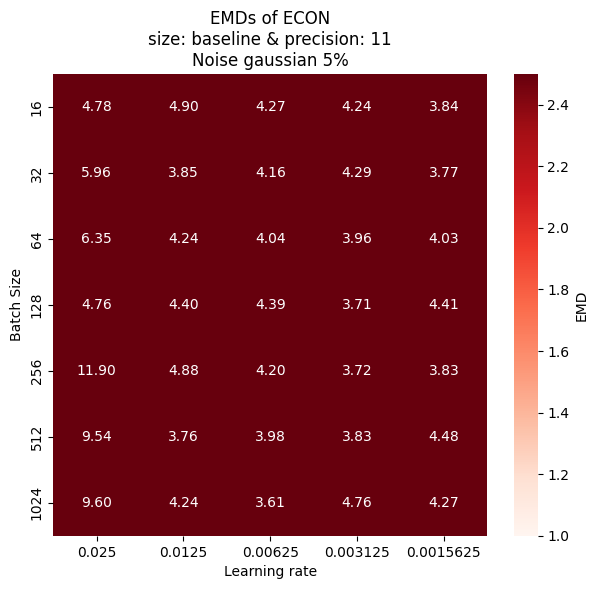

In [22]:
MIN_EMD = 1.5
emd_distribution = []
robust_rank = []
for p in precisions:
    EMD_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            noise_emd_5 = get_emd_with_noise(bs, lr, p, size, noise_type, 5)
            noise_emd_10 = get_emd_with_noise(bs, lr, p, size, noise_type, 10)
            noise_emd_15 = get_emd_with_noise(bs, lr, p, size, noise_type, 15)
            noise_emd_20 = get_emd_with_noise(bs, lr, p, size, noise_type, 20)
            original_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            EMD_matrix[x, y] = noise_emd_20
            emd_distribution.append({
                'precision': p, 
                'emd': original_emd,
                'type': 'original',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': 0
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_5,
                'type': '5%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_5 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_10,
                'type': '10%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_10 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_15,
                'type': '15%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_15 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            emd_distribution.append({
                'precision': p, 
                'emd': noise_emd_20,
                'type': '20%',
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'precision': p,
                'loss': (noise_emd_20 - original_emd) * 100 / original_emd,
                'original_emd': original_emd
            })
            
            
            
    # heat map of the EMD with noise as input per precision
    EMD_matrix = pd.DataFrame(EMD_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    
    plot_2d_heatmap(EMD_matrix, 
                    f'EMDs of ECON\nsize: {size} & precision: {p}\n' \
                    f'Noise {noise_type} 5%', 
                    (1, 2.5),
                    'Learning rate',
                    'Batch Size',
                    'EMD')
        
emd_distribution_df = pd.DataFrame(emd_distribution)
emd_distribution_df = emd_distribution_df.loc[emd_distribution_df.emd > 0]

In [16]:
top_5_noise = emd_distribution_df.loc[emd_distribution_df.type == '5%']
top_5_noise = top_5_noise.sort_values(by='original_emd', ascending=True)
top_5_noise.head(10)

precision       emd type batch_size learning_rate        loss  \
1266         10  3.299116   5%         32      0.003125  198.658953   
621           6  2.093310   5%        128     0.0015625   89.305970   
1096          9  2.935274   5%         32     0.0015625  163.455287   
1421         11  3.136834   5%         16     0.0015625  179.831705   
1466         11  3.757545   5%         64      0.003125  234.550832   
1296         10  2.940475   5%         64     0.0015625  161.088665   
921           8  2.894459   5%         32     0.0015625  156.824785   
1471         11  3.419063   5%         64     0.0015625  203.211435   
946           8  2.683540   5%         64     0.0015625  137.907868   
771           7  2.156388   5%         64     0.0015625   90.414483   

      original_emd  
1266      1.104643  
621       1.105781  
1096      1.114145  
1421      1.120972  
1466      1.123161  
1296      1.126236  
921       1.127017  
1471      1.127617  
946       1.127975  
771       1.132471

Text(0.5, 1.0, 'EMD of the best models at different precisions with 5% of noise')

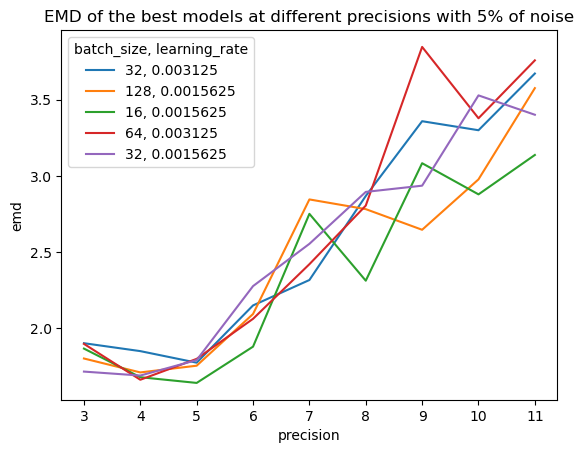

In [17]:
top_5_noise = top_5_noise.loc[
    (top_5_noise.batch_size == '32') & (top_5_noise.learning_rate == '0.003125') |
    (top_5_noise.batch_size == '128') & (top_5_noise.learning_rate == '0.0015625') |
    (top_5_noise.batch_size == '32') & (top_5_noise.learning_rate == '0.0015625') |
    (top_5_noise.batch_size == '16') & (top_5_noise.learning_rate == '0.0015625') |
    (top_5_noise.batch_size == '64') & (top_5_noise.learning_rate == '0.003125')
    ]

top_5_noise = top_5_noise.sort_values(by='precision', ascending=False)

hue = top_5_noise[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_noise, x='precision', y='emd', hue=hue, orient="x")
plt.title("EMD of the best models at different precisions with 5% of noise")

Text(0.5, 1.0, 'EMD of the best models at different leraning rates with 5% of noise')

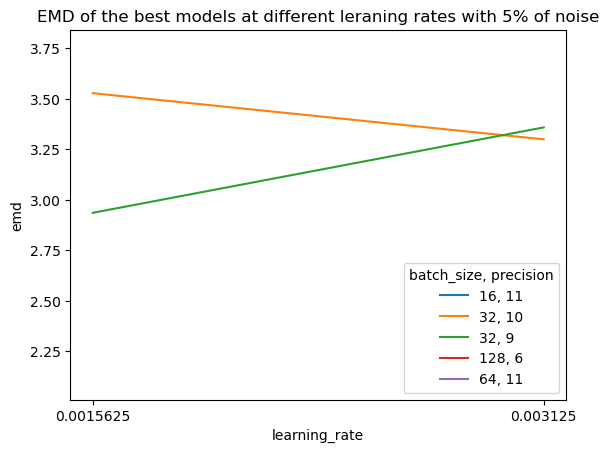

In [18]:
top_5_noise = top_5_noise.loc[
    (top_5_noise.batch_size == '32') & (top_5_noise.precision == 10) |
    (top_5_noise.batch_size == '128') & (top_5_noise.precision == 6) |
    (top_5_noise.batch_size == '32') & (top_5_noise.precision == 9) |
    (top_5_noise.batch_size == '16') & (top_5_noise.precision == 11) |
    (top_5_noise.batch_size == '64') & (top_5_noise.precision == 11)
    ]

top_5_noise = top_5_noise.sort_values(by='learning_rate', ascending=True)

hue = top_5_noise[['batch_size', 'precision']] \
        .apply(lambda row: f"{row.batch_size}, {row.precision}", axis=1)
hue.name = 'batch_size, precision'

sns.lineplot(top_5_noise, x='learning_rate', y='emd', hue=hue)
plt.title("EMD of the best models at different leraning rates with 5% of noise")

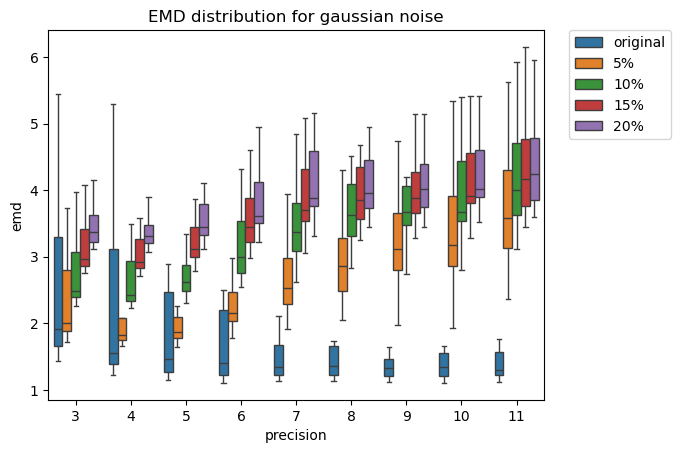

In [19]:
sns.boxplot(data=emd_distribution_df, 
            x='precision', 
            y='emd',
            hue='type',
            showfliers=False)

plt.title(f'EMD distribution for {noise_type} noise')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

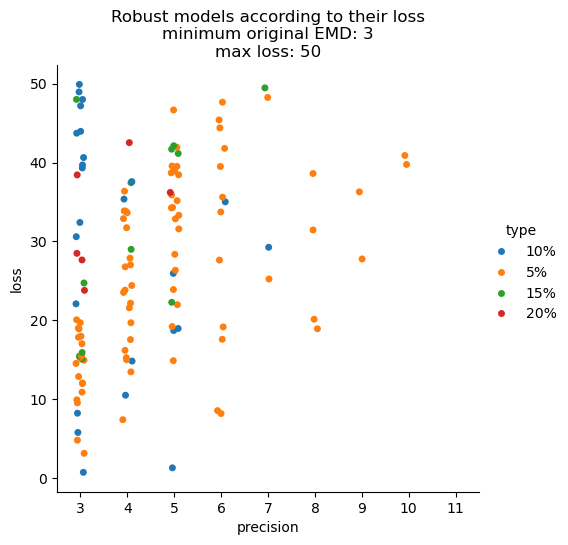

In [20]:
MAX_LOSS = 50
MAX_EMD = 3
# filter the entries 
robust_df = emd_distribution_df.sort_values(by=['loss', 'original_emd'], ascending=[True, True])
robust_df = robust_df.drop(robust_df[robust_df.type == 'original'].index)
robust_df = robust_df.drop(robust_df[(robust_df.loss < 0) | (robust_df.loss > MAX_LOSS)].index)
robust_df = robust_df.drop(robust_df[robust_df.original_emd > MAX_EMD].index)

sns.catplot(robust_df, y='loss', x='precision', hue='type', order=precisions)
plt.title(f'Robust models according to their loss\n' \
          f'minimum original EMD: {MAX_EMD}\n' \
          f'max loss: {MAX_LOSS}')
plt.show()

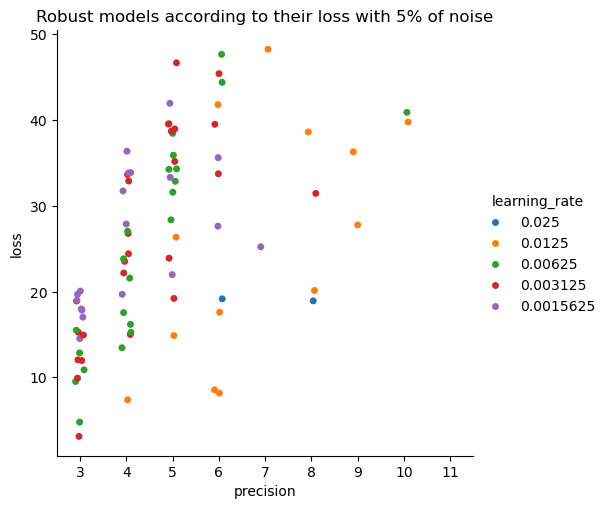

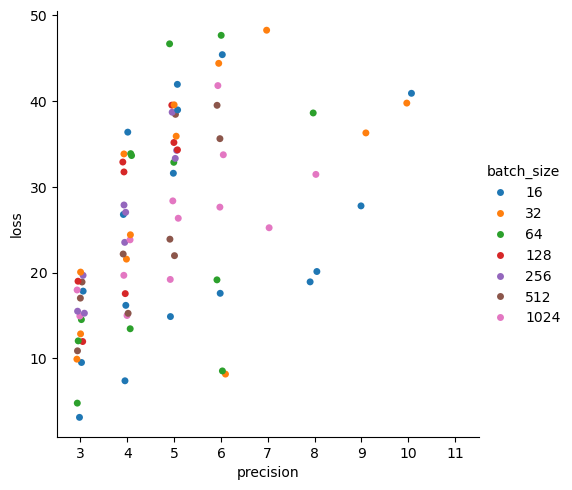

   original_emd       loss batch_size learning_rate  precision
0      1.860878   3.138007         16      0.003125          3
1      1.919065   4.798361         64       0.00625          3
2      1.910940   7.400822         16        0.0125          4
3      2.245751   8.182710         32        0.0125          6
4      2.049524   8.550996         64        0.0125          6
5      1.967709   9.534754         16       0.00625          3
6      1.729949   9.922525         32      0.003125          3
7      1.709671  10.893808        512       0.00625          3
8      1.691347  11.978386        128      0.003125          3
9      1.693192  12.054004         64      0.003125          3
    original_emd       loss batch_size learning_rate  precision
72      1.270912  39.569528         32      0.003125          5
73      1.461834  39.771948         32        0.0125         10
74      1.369688  40.912487         16       0.00625         10
75      1.376757  41.811120       1024        0.012

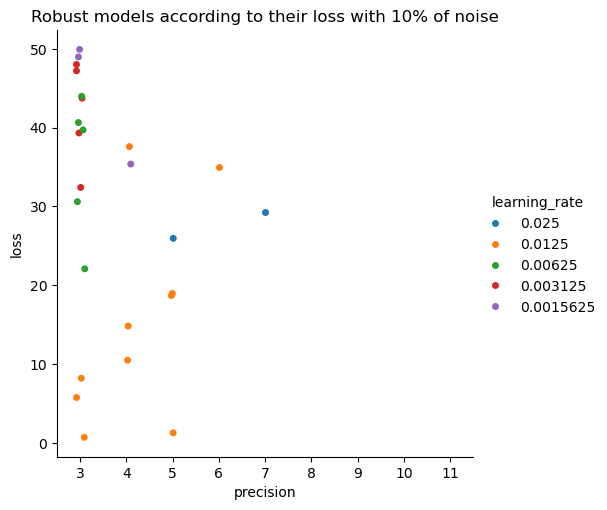

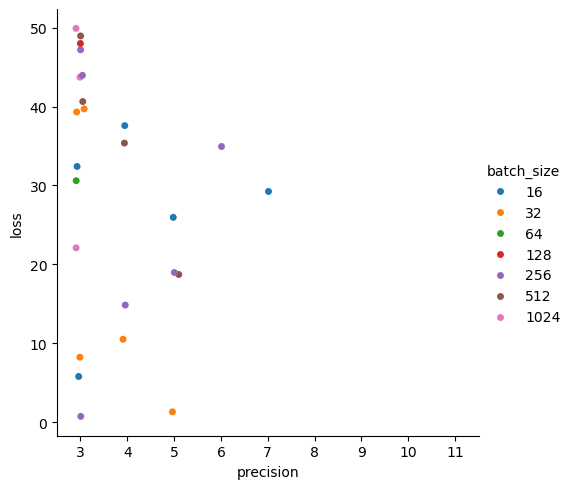

   original_emd       loss batch_size learning_rate  precision
0      2.479948   0.726937        256        0.0125          3
1      2.876875   1.297771         32        0.0125          5
2      2.931284   5.781862         16        0.0125          3
3      2.738463   8.224824         32        0.0125          3
4      2.375551  10.505084         32        0.0125          4
5      2.214235  14.838048        256        0.0125          4
6      2.285544  18.711903        512        0.0125          5
7      2.234362  18.968007        256        0.0125          5
8      1.958069  22.097315       1024       0.00625          3
9      2.655157  25.959411         16         0.025          5
    original_emd       loss batch_size learning_rate  precision
15      1.910940  37.597840         16        0.0125          4
16      1.729949  39.325586         32      0.003125          3
17      1.817719  39.710422         32       0.00625          3
18      1.709671  40.648277        512       0.0062

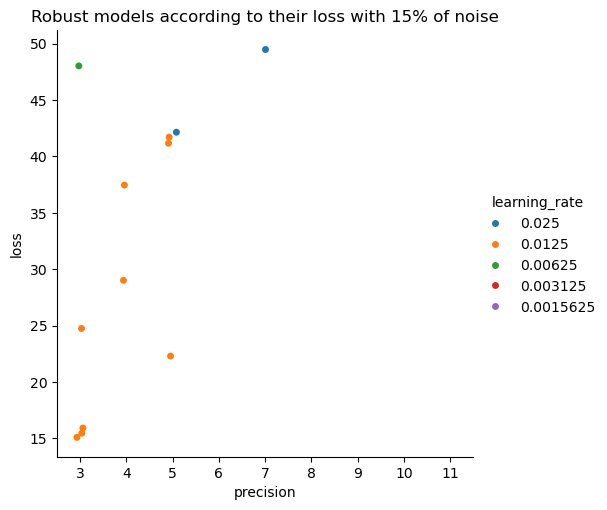

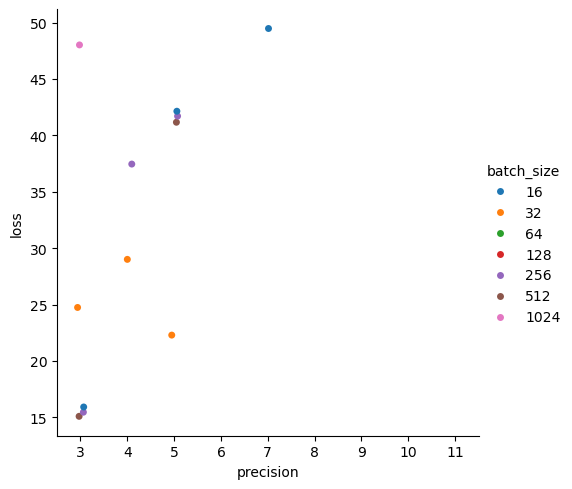

   original_emd       loss batch_size learning_rate  precision
0      2.559708  15.090062        512        0.0125          3
1      2.479948  15.456090        256        0.0125          3
2      2.931284  15.917443         16        0.0125          3
3      2.876875  22.290658         32        0.0125          5
4      2.738463  24.741362         32        0.0125          3
5      2.375551  29.005498         32        0.0125          4
6      2.214235  37.454511        256        0.0125          4
7      2.285544  41.161782        512        0.0125          5
8      2.234362  41.704766        256        0.0125          5
9      2.655157  42.139292         16         0.025          5
    original_emd       loss batch_size learning_rate  precision
2       2.931284  15.917443         16        0.0125          3
3       2.876875  22.290658         32        0.0125          5
4       2.738463  24.741362         32        0.0125          3
5       2.375551  29.005498         32        0.012

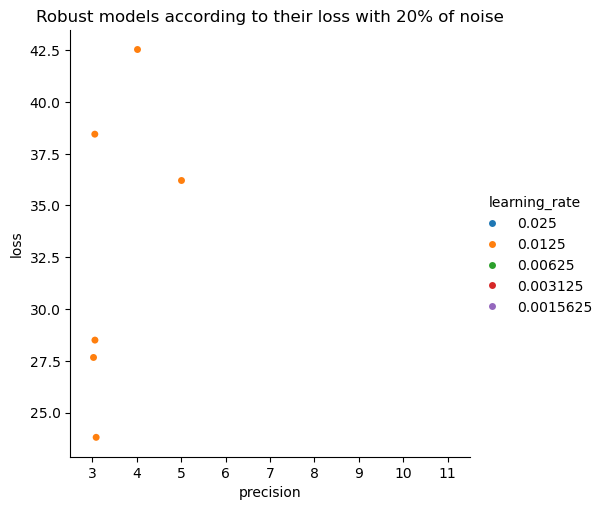

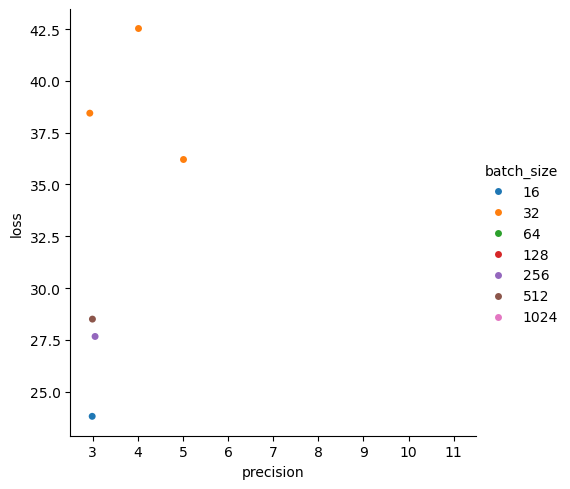

   original_emd       loss batch_size learning_rate  precision
0      2.931284  23.806723         16        0.0125          3
1      2.479948  27.662769        256        0.0125          3
2      2.559708  28.500830        512        0.0125          3
3      2.876875  36.220181         32        0.0125          5
4      2.738463  38.444167         32        0.0125          3
5      2.375551  42.537106         32        0.0125          4
   original_emd       loss batch_size learning_rate  precision
0      2.931284  23.806723         16        0.0125          3
1      2.479948  27.662769        256        0.0125          3
2      2.559708  28.500830        512        0.0125          3
3      2.876875  36.220181         32        0.0125          5
4      2.738463  38.444167         32        0.0125          3
5      2.375551  42.537106         32        0.0125          4


In [21]:
noise_levels = [5, 10, 15, 20]
for noise in noise_levels:
    # Check the most robust models per noise
    df = robust_df.drop(robust_df[robust_df.type != f'{noise}%'].index)
    df = df.reset_index()
    
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='learning_rate', 
                order=precisions, 
                hue_order=[str(x) for x in learning_rates])
    plt.title(f'Robust models according to their loss with {noise}% of noise')
    sns.catplot(df, 
                x='precision', 
                y='loss', 
                hue='batch_size', 
                order=precisions, 
                hue_order=[str(x) for x in batch_sizes])
    plt.show()
    print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].head(10))
    print(df[['original_emd', 'loss', 'batch_size', 'learning_rate', 'precision']].tail(10))
    df.to_csv(f"./out{noise}.csv")

### NOTE
*small*:
By adding noise we observe a strange behavior, the EMD values are less spread but really high, with 25% of noise we already have too high values. Small precisions seems to handle noise better respect to high precision.
*baseline*
Same behavior of small

# Neural efficiency analysis

In [22]:
NE_DATA_DIR = "/home/jovyan/checkpoint/"

def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision,
                          size, 
                          data_loader,
                          max_batches=None,
                          beta=-2):
    path = os.path.join(NE_DATA_DIR, f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/')
    model, emd =load_model(batch_size, learning_rate, precision, size)
    metric = NeuralEfficiency(model, data_loader, performance=emd, max_batches=max_batches,
                              target_layers=['encoder.conv', 'encoder.enc_dense'])
    
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            return {'network_efficiency': -1}
    
    
    result = metric.compute(beta=beta)
    metric.save_on_file(path=path)
    
    return result

def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    plt.figure(figsize=(12,6))
    
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()
    

In [23]:
ne_dataloader = get_data_module(1).test_dataloader()
ne_batch_num = 50000
robust_df.drop(robust_df[robust_df.type != '5%'].index, inplace=True)

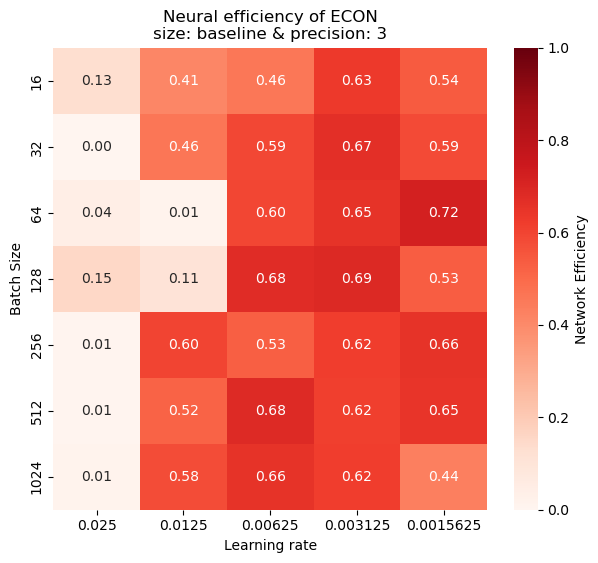

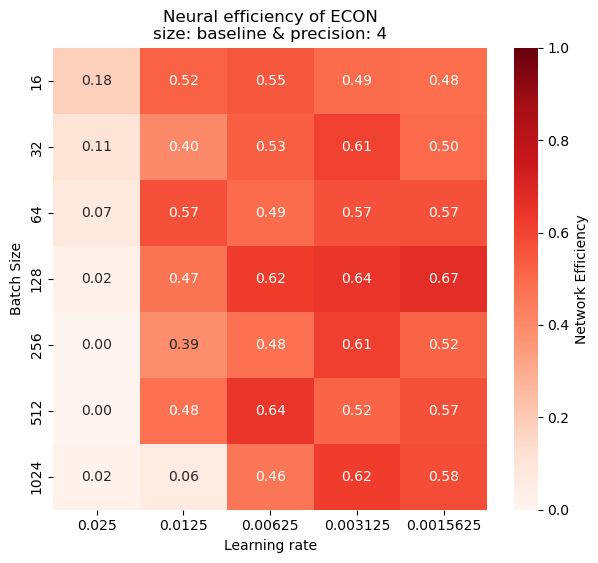

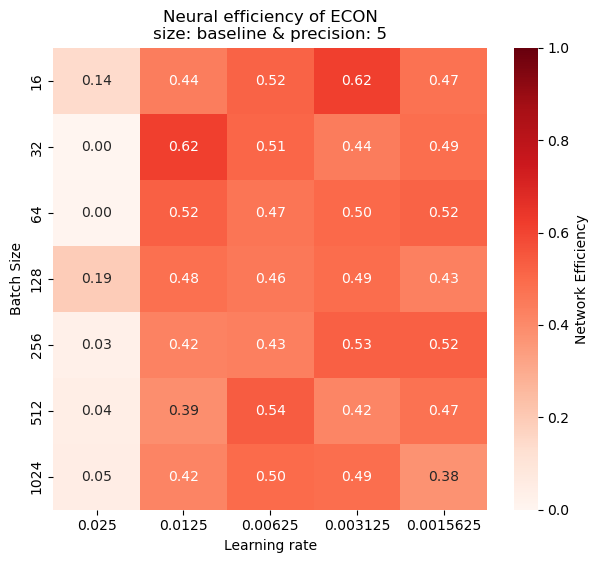

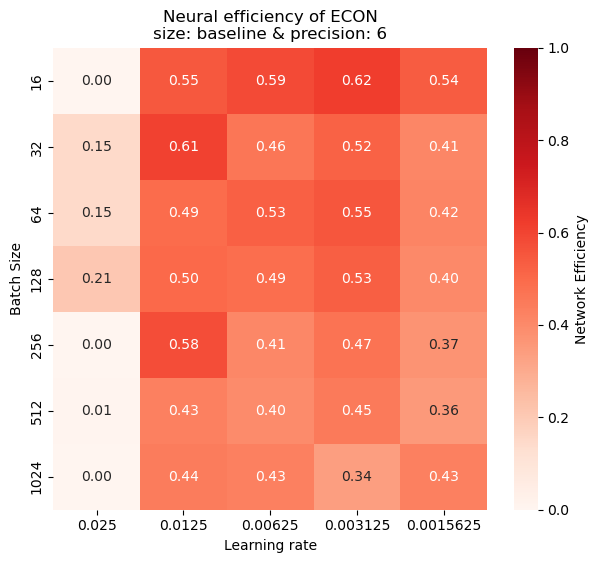

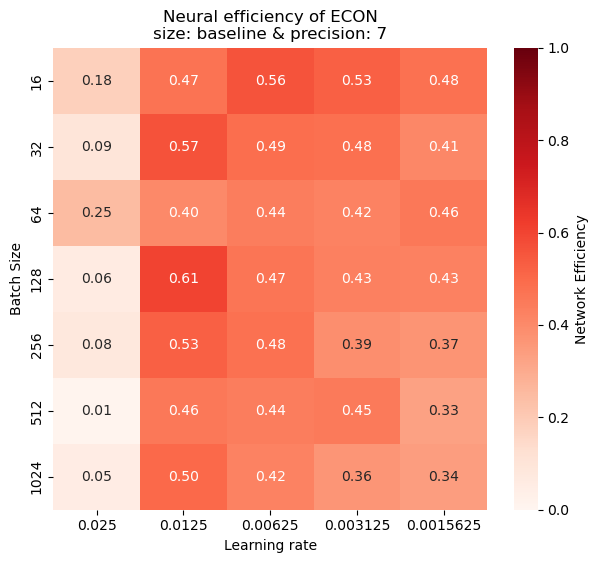

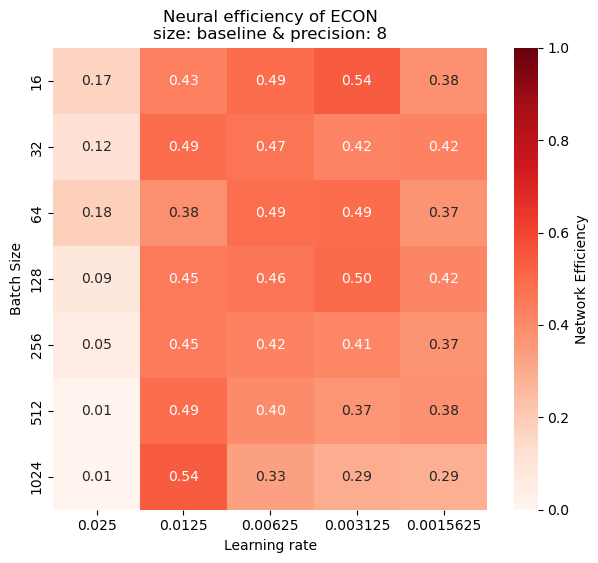

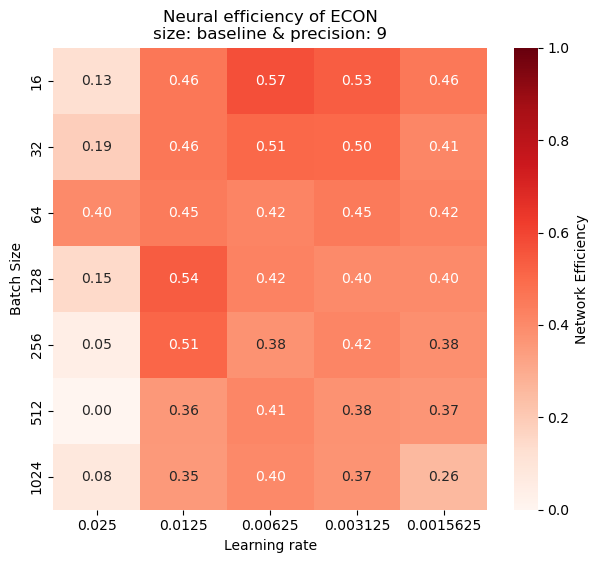

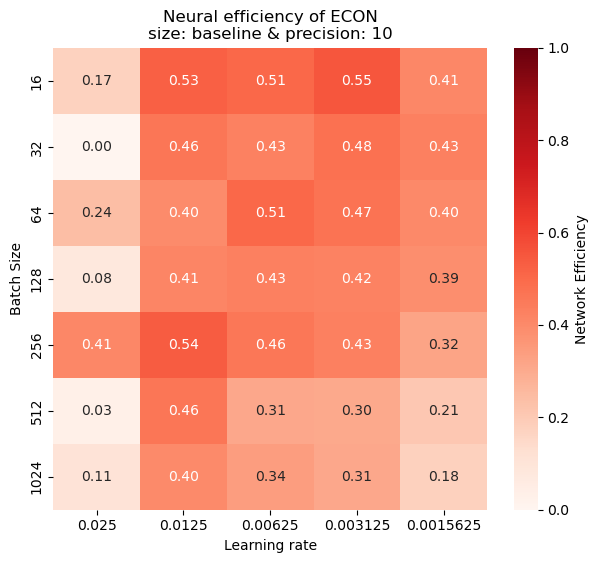

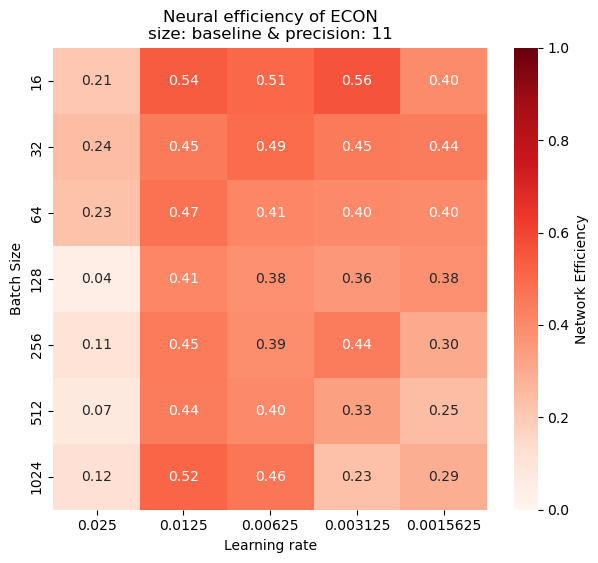

In [29]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            mean_emd, _ = get_model_index_and_relative_EMD(bs, lr, p, size)
            noise_emd_5 = get_emd_with_noise(bs, lr, p, size, noise_type, 5)
            result = get_neural_efficiency(bs,
                                           lr,
                                           p,
                                           size,
                                           ne_dataloader,
                                           max_batches=ne_batch_num)
            
            NE_matrix[x, y] = result['network_efficiency']
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result['network_efficiency'],
                'accuracy': mean_emd,
                'noise_acc': noise_emd_5,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd_5 - mean_emd) * 100 / mean_emd,
            })
            
    NE_matrix = pd.DataFrame(NE_matrix, 
                                    index=batch_sizes, 
                                    columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency')
    
ne_distribution_df = pd.DataFrame(ne_distribution)

Text(0.5, 1.0, 'Network efficiency of the best models at different precisions')

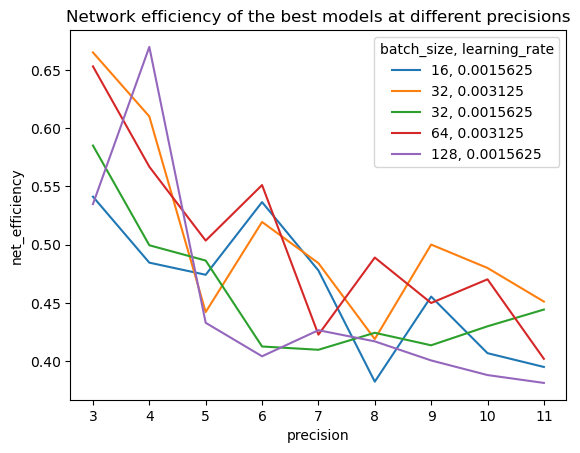

In [30]:
top_5_df = ne_distribution_df.loc[
    (ne_distribution_df.batch_size == '32') & (ne_distribution_df.learning_rate == '0.003125') |
    (ne_distribution_df.batch_size == '128') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '32') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the best models at different precisions")

Text(0.5, 1.0, 'Network efficiency of the robust models at different precisions')

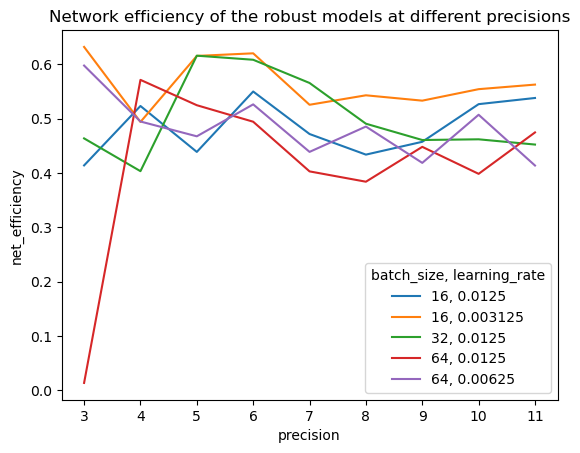

In [32]:
top_5_df = ne_distribution_df.loc[
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.003125') |
    (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.00625') |
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '32') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.0125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the robust models at different precisions")

--------------------------------------------------------------------------------
Low loss
Accuracy:	1.860877513885498
Loss:	3.1380067876381372
Network efficiency:	0.6317732287609304


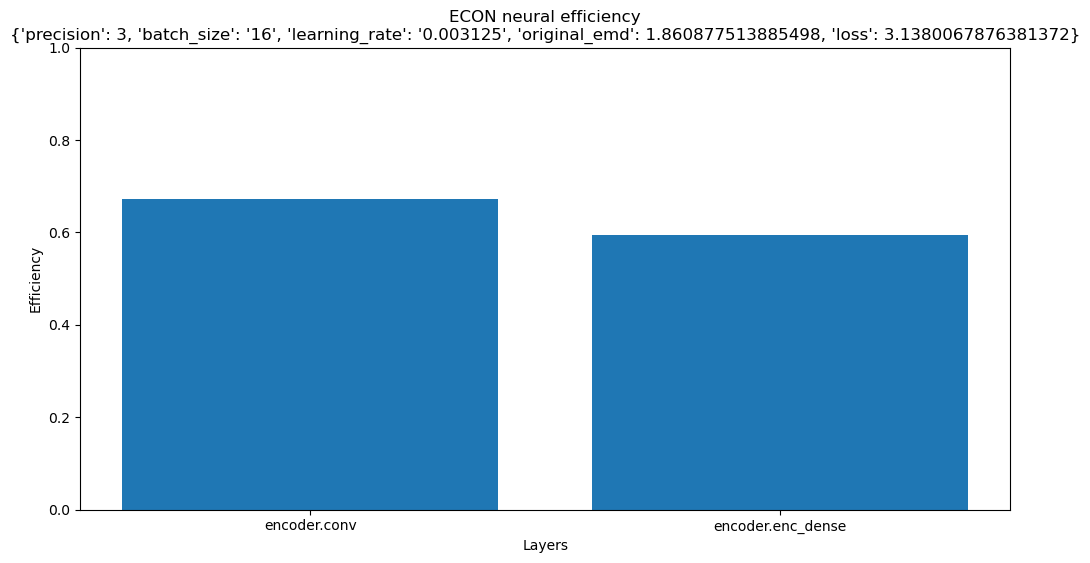

--------------------------------------------------------------------------------
High loss
Accuracy:	2.108998696009318
Loss:	48.2670340607757
Network efficiency:	0.5654480066201751


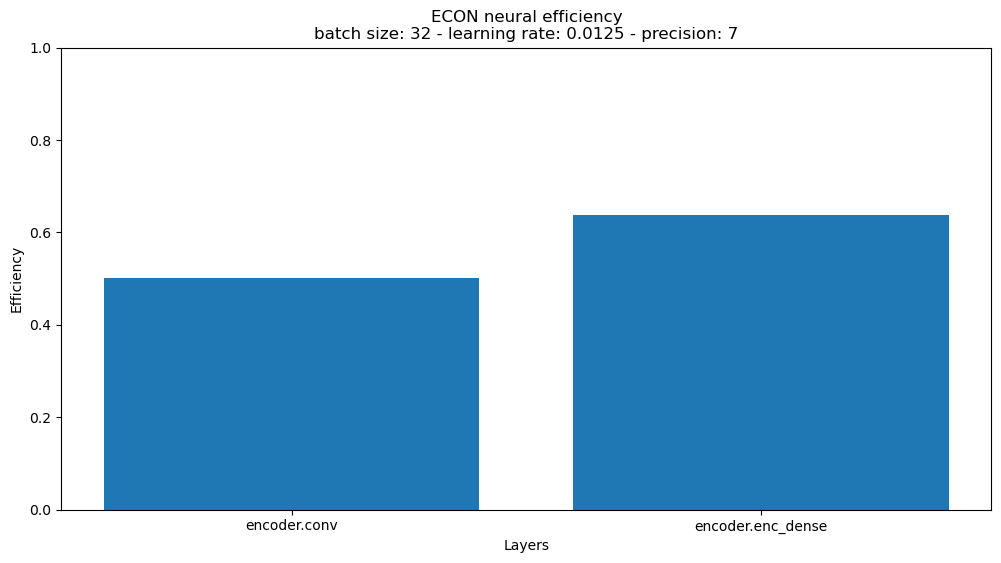

--------------------------------------------------------------------------------
Low loss
Accuracy:	1.9190647999445598
Loss:	4.798360785779066
Network efficiency:	0.5975000562322365


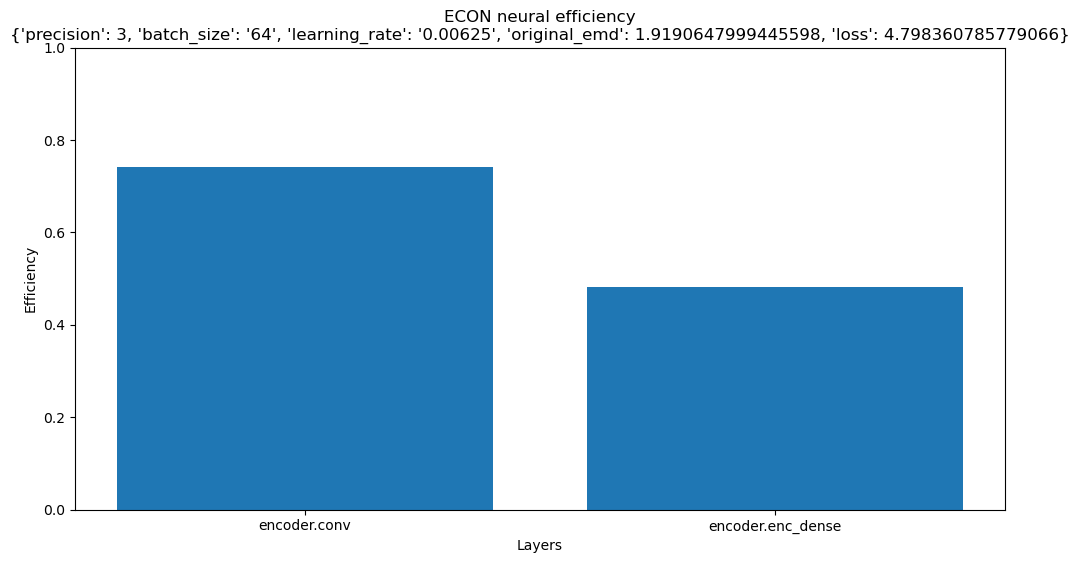

--------------------------------------------------------------------------------
High loss
Accuracy:	1.2964364687601726
Loss:	47.6697648603753
Network efficiency:	0.526064894122629


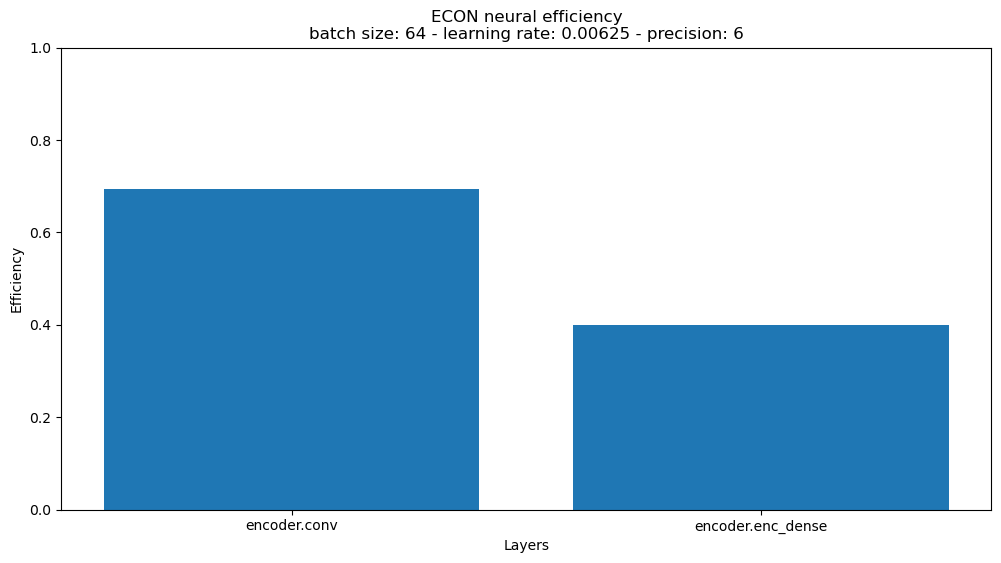

--------------------------------------------------------------------------------
Low loss
Accuracy:	1.9109400113423665
Loss:	7.40082152267592
Network efficiency:	0.5230909399437863


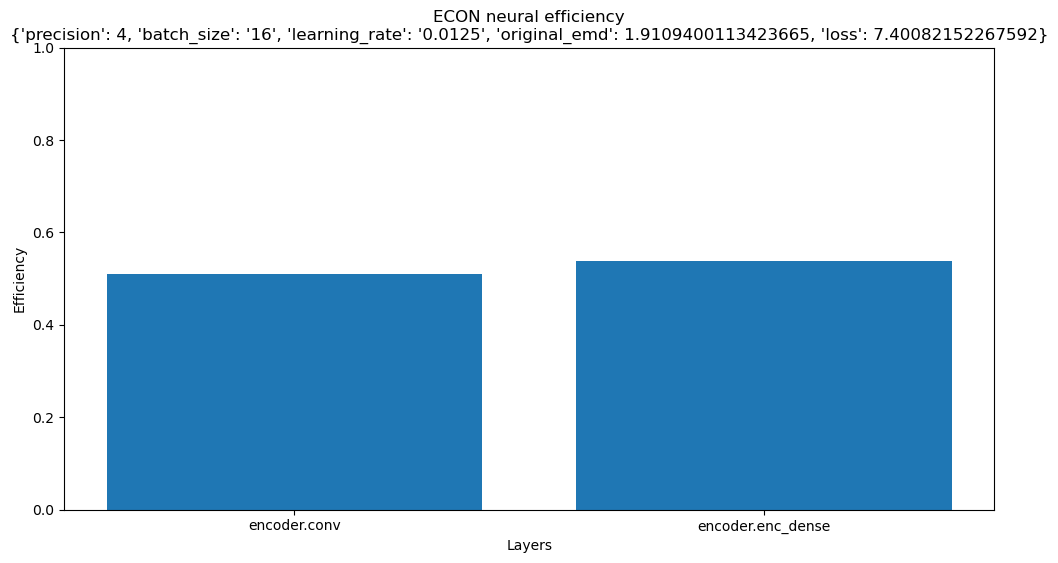

--------------------------------------------------------------------------------
High loss
Accuracy:	1.2263822952906291
Loss:	46.67970021372895
Network efficiency:	0.503602644381443


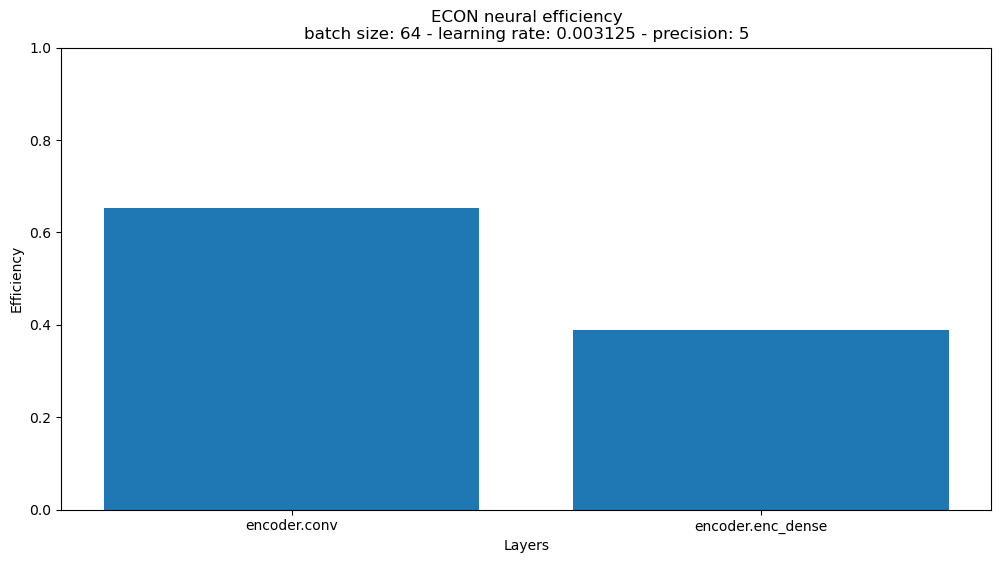

In [33]:
ranking_robust = robust_df[
        ['precision', 'batch_size', 'learning_rate', 'original_emd', 'loss']
                            ].to_dict('records')

for i in range(3):
    worst_index = -(i+1)    # last in the ranking
    best_index = i
    
    print('-'*80)
    print('Low loss')
    result = get_neural_efficiency(int(ranking_robust[best_index]['batch_size']),
                            float(ranking_robust[best_index]['learning_rate']), 
                            int(ranking_robust[best_index]['precision']),
                            size,
                            ne_dataloader,
                            max_batches=ne_batch_num)
    print(f"Accuracy:\t{ranking_robust[best_index]['original_emd']}\n" \
            f"Loss:\t{ranking_robust[best_index]['loss']}\n" \
            f"Network efficiency:\t{result['network_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                       'ECON neural efficiency\n' \
                                      f'{ranking_robust[best_index]}')

    print('-'*80)
    print('High loss')
    result = get_neural_efficiency(int(ranking_robust[worst_index]['batch_size']),
                                   float(ranking_robust[worst_index]['learning_rate']), 
                                   int(ranking_robust[worst_index]['precision']),
                                   size,
                                   ne_dataloader,
                                   max_batches=ne_batch_num)

    print(f"Accuracy:\t{ranking_robust[worst_index]['original_emd']}\n" \
            f"Loss:\t{ranking_robust[worst_index]['loss']}\n" \
            f"Network efficiency:\t{result['network_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                    f"batch size: {ranking_robust[worst_index]['batch_size']} - " \
                                    f"learning rate: {ranking_robust[worst_index]['learning_rate']} - " \
                                    f"precision: {ranking_robust[worst_index]['precision']}" )

# CKA similarity anlysis

In [25]:
CKA_DATA_DIR = "/home/jovyan/checkpoint/"

def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      size,
                      data_loader,
                      activation_layers,
                      max_batches=1000):
    model, _ = load_model(batch_size, learning_rate, precision, size)
    cka = CKA(model, 
              data_loader, 
              layers=activation_layers,
              max_batches=max_batches)
    return cka


def compute_distance(cka, batch_size, learning_rate, precision, size, load=True):
    # check if distance already computed
    if load:
        cka.name += f'_{size}_bs{batch_size}_lr{learning_rate}_p{precision}'
        if cka.load_from_file(CKA_DATA_DIR):
            return cka.results
        
    model, _ = load_model(batch_size, learning_rate, precision, size)
    # look if the result has been already computed
    result = cka.compare(model, cka.layers)
    
    # store the result on file
    if not os.path.exists(CKA_DATA_DIR):
        os.mkdir(CKA_DATA_DIR)
        
    cka.save_on_file(path=CKA_DATA_DIR)
    return result



## Structural Analysis
This metric can be used to carry analysis about the internal structure of the model, indeed the CKA similarity is used in XAI field to try to understand the path learned by the model. We are going to use that to see the difference between extreme cases, for both good and bad models.

*Note*: Due to the architecture of ECON encoder we are only interested in the values on the diagonal of the heatmap, because it does not make sense to compare a Conv layer with a Dense layer.

In [26]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
cka_dataloader = get_data_module(16).test_dataloader()
cka_batch_num = 100000
econ_layers = ['encoder.conv', 'encoder.enc_dense']
robust_df.drop(robust_df[robust_df.type != '5%'].index, inplace=True)

/home/jovyan/checkpoint/bs16_lr0.025/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_3b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_3b/baseli

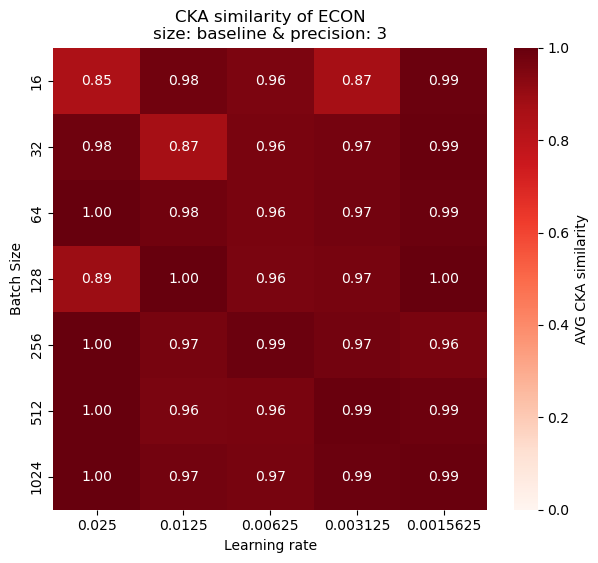

/home/jovyan/checkpoint/bs16_lr0.025/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_4b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_4b/baseli

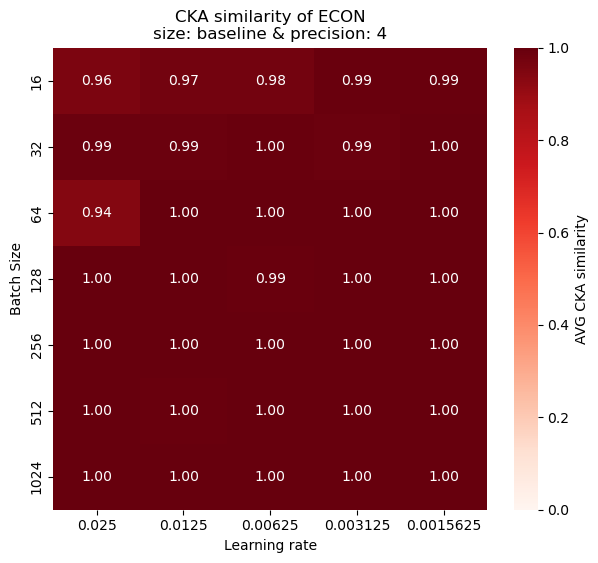

/home/jovyan/checkpoint/bs16_lr0.025/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_5b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_5b/baseli

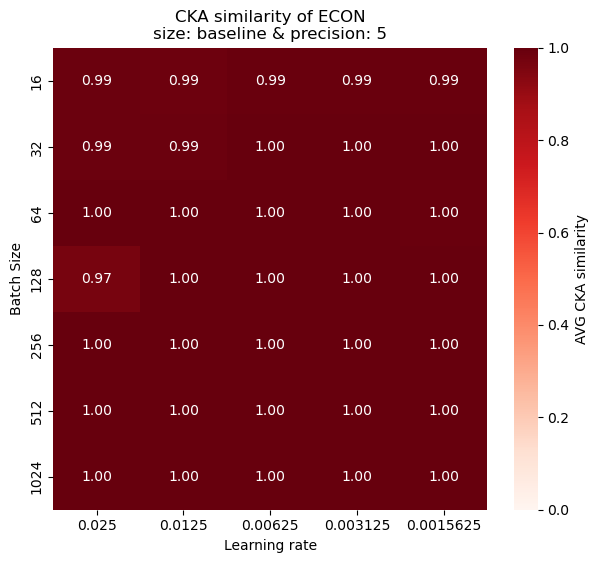

/home/jovyan/checkpoint/bs16_lr0.025/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_6b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_6b/baseli

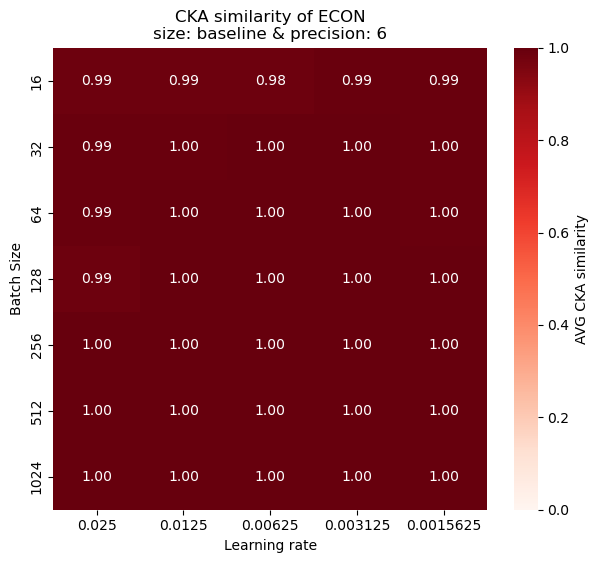

/home/jovyan/checkpoint/bs16_lr0.025/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_7b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_7b/baseli

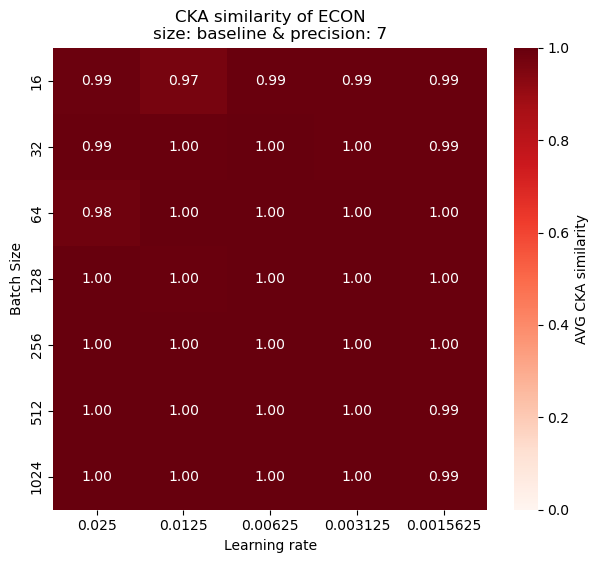

/home/jovyan/checkpoint/bs16_lr0.025/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_8b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_8b/baseli

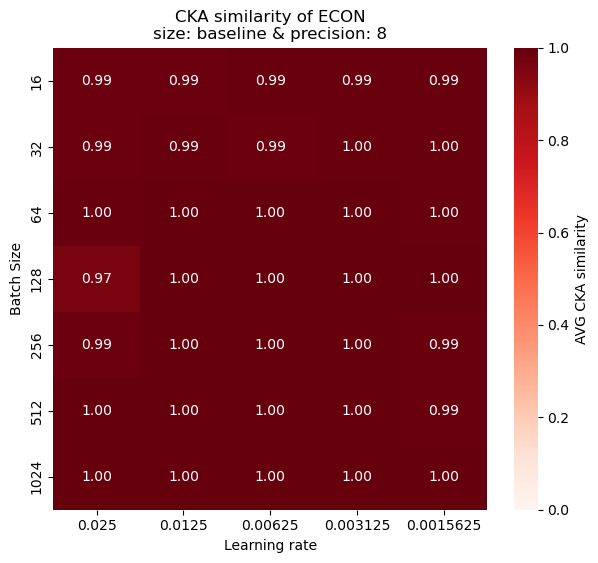

/home/jovyan/checkpoint/bs16_lr0.025/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_9b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/ECON_9b/baseli

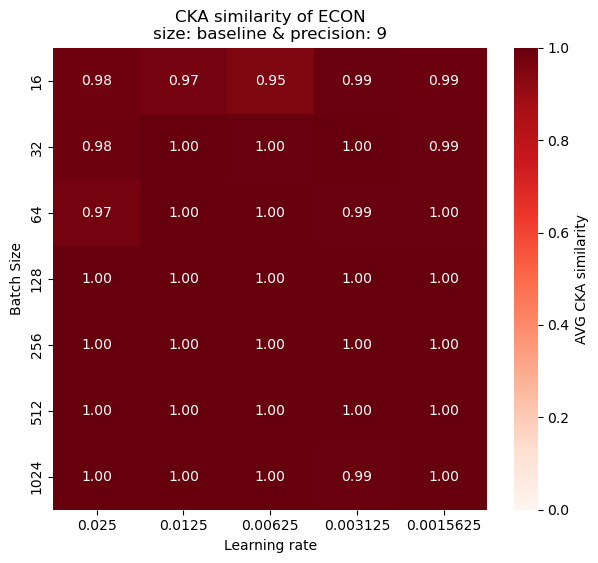

/home/jovyan/checkpoint/bs16_lr0.025/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_10b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/E

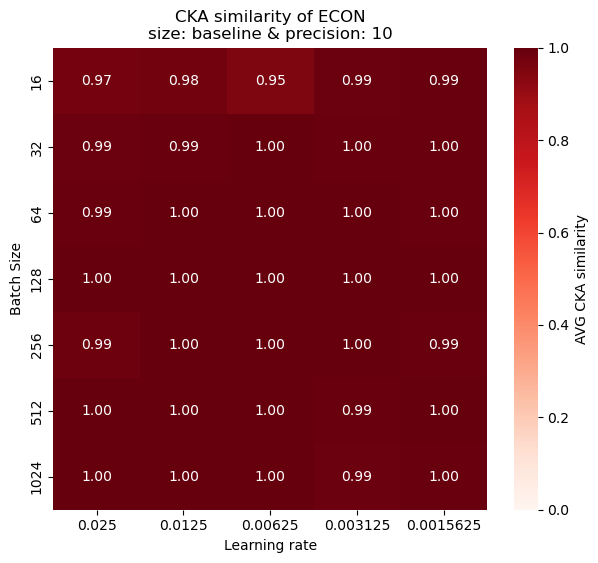

/home/jovyan/checkpoint/bs16_lr0.025/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0125/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.00625/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.003125/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs16_lr0.0015625/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.025/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0125/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.00625/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.003125/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs32_lr0.0015625/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.025/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.0125/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.00625/ECON_11b/baseline/
CUDA available!
/home/jovyan/checkpoint/bs64_lr0.003125/E

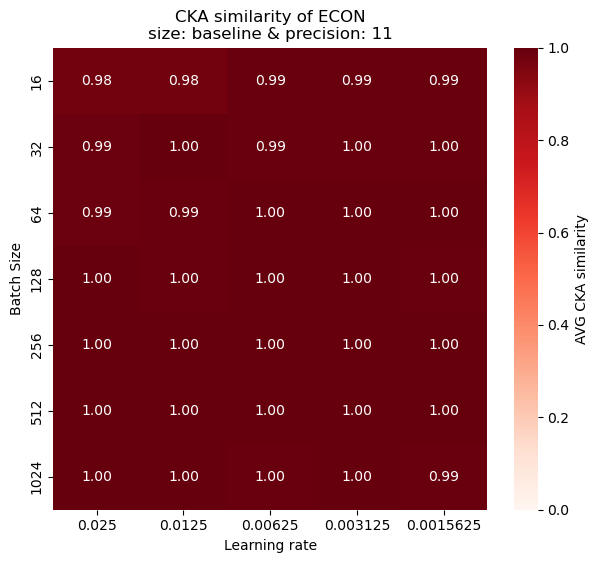

In [28]:
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            path = os.path.join(CKA_DATA_DIR, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            print(path)
            cka = get_cka_per_model(bs,
                                           lr,
                                           p,
                                           size,
                                           cka_dataloader,
                                           econ_layers,
                                           max_batches=cka_batch_num)
            avg_cka = -1
            if cka.load_from_file(path):
                result = cka.results['internal_cka'].detach().cpu().numpy()
                avg_cka = (np.sum(result) - np.sum(result.diagonal())) / (result.shape[0]**2 - result.shape[0])

            CKA_matrix[x, y] = avg_cka
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                                    index=batch_sizes, 
                                    columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity')

let's see the CKA similarity per layer of the robust models

--------------------------------------------------------------------------------
Low loss
CUDA available!


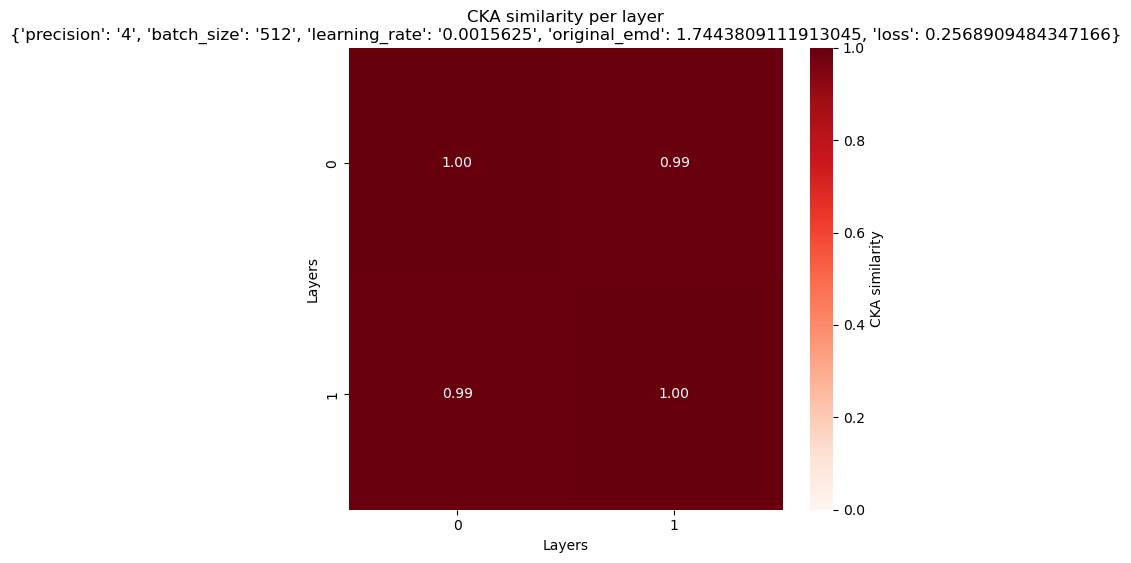

--------------------------------------------------------------------------------
High loss
CUDA available!


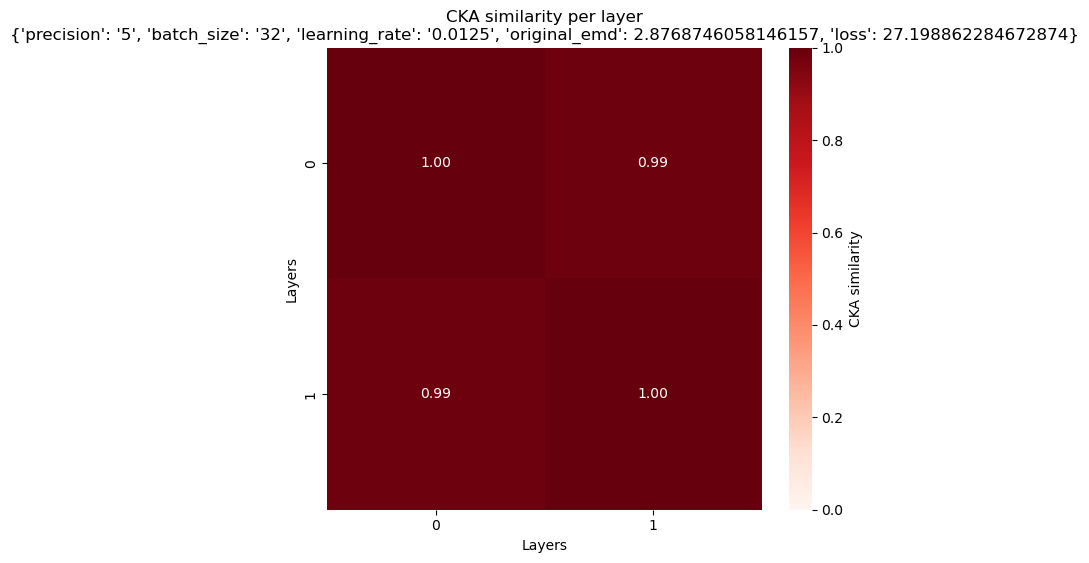

--------------------------------------------------------------------------------
Low loss
CUDA available!


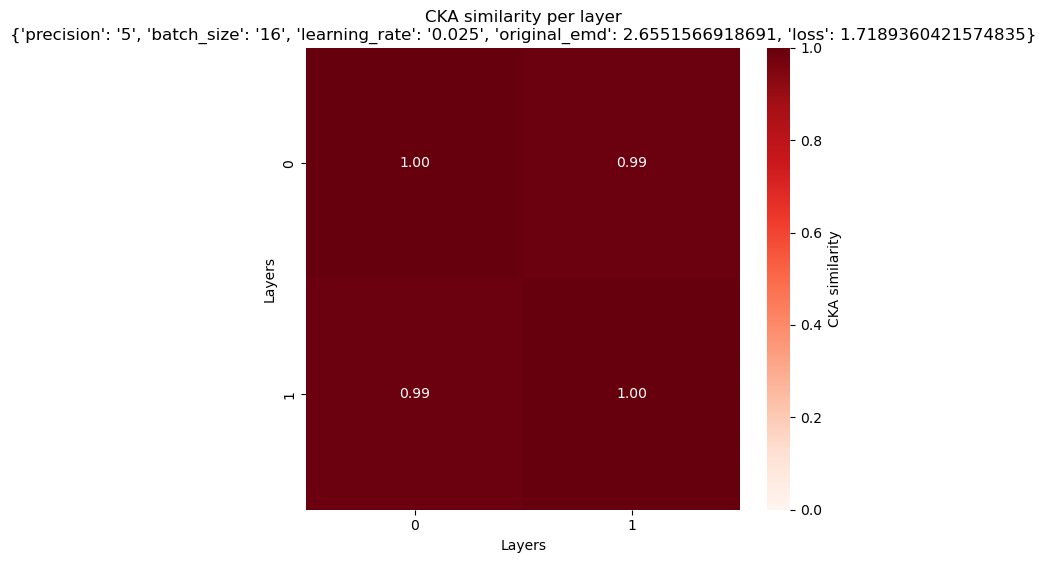

--------------------------------------------------------------------------------
High loss
CUDA available!


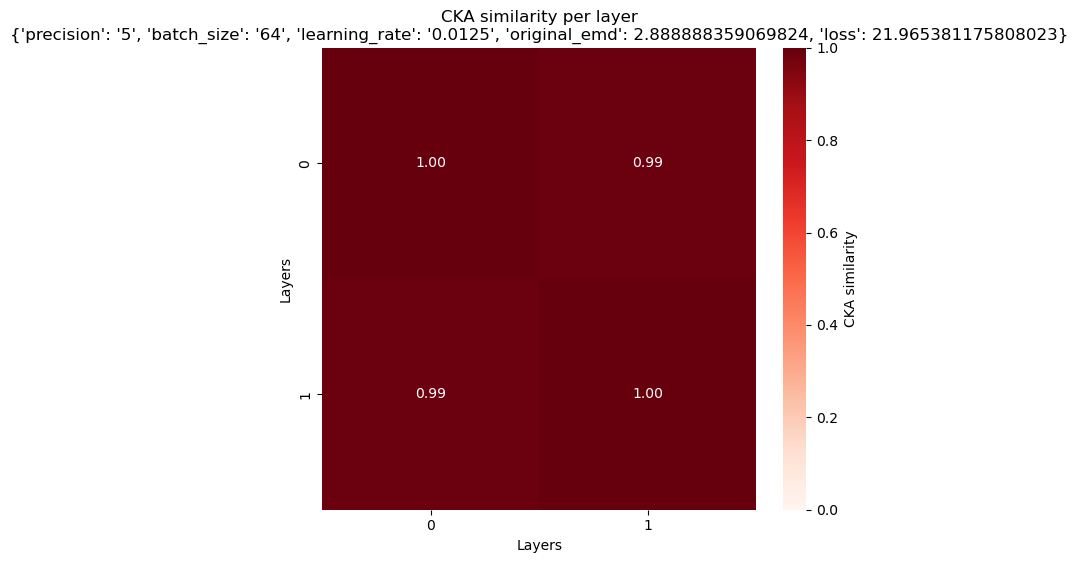

--------------------------------------------------------------------------------
Low loss
CUDA available!


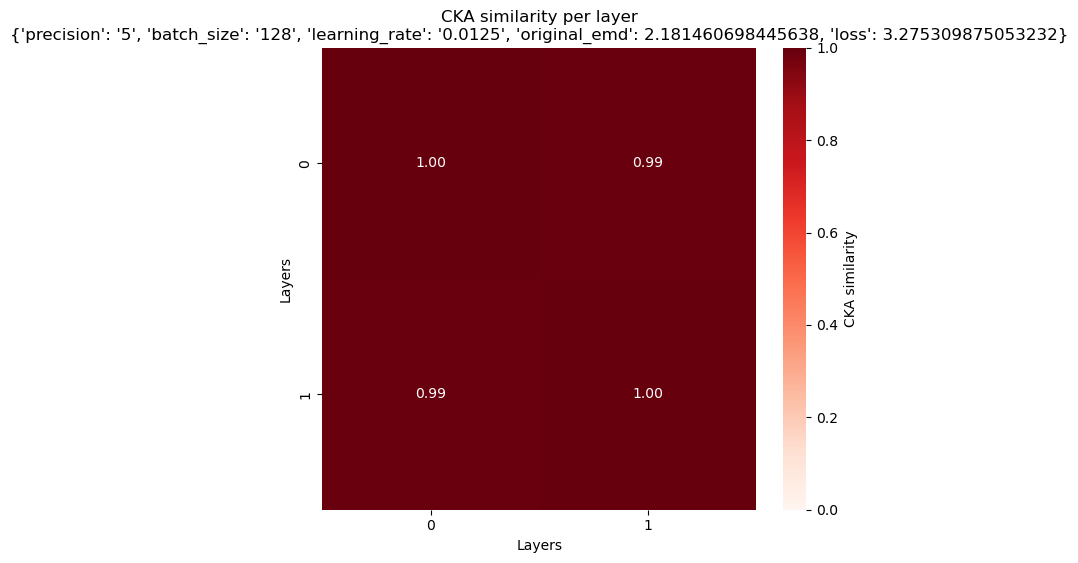

--------------------------------------------------------------------------------
High loss
CUDA available!


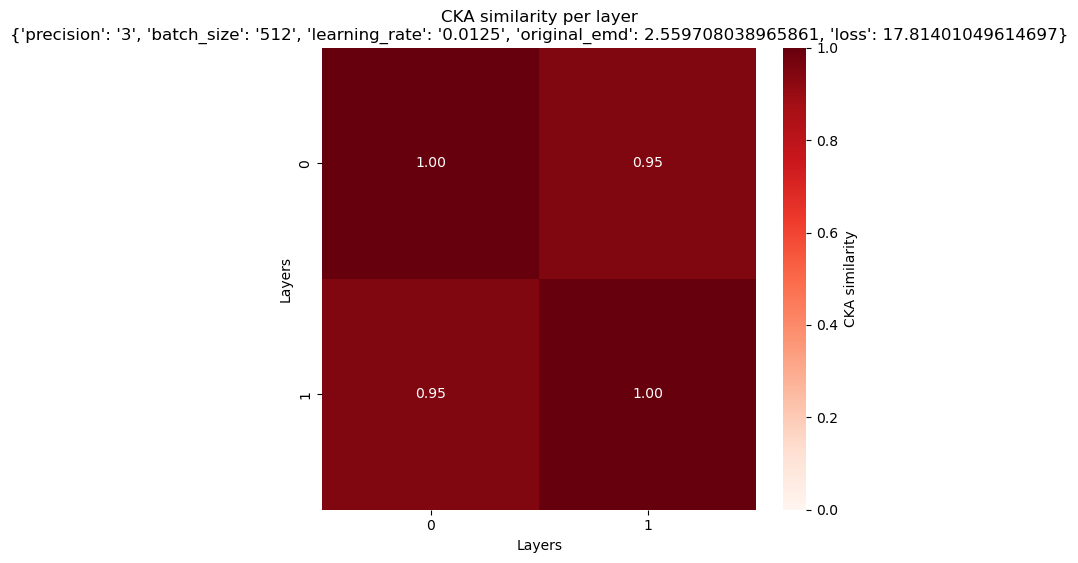

In [21]:
ranking_robust = robust_df[['precision', 'batch_size', 'learning_rate', 'original_emd', 'loss']].to_dict('records')

for i in range(3):
    worst_index = -(i+1)    # last in the ranking
    best_index = i
    
    print('-'*80)
    print('Low loss')
    cka = get_cka_per_model(int(ranking_robust[best_index]['batch_size']),
                            float(ranking_robust[best_index]['learning_rate']), 
                            int(ranking_robust[best_index]['precision']),
                            size,
                            cka_dataloader,
                            econ_layers,
                            cka_batch_num)

    results = cka.compute()
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{ranking_robust[best_index]}", 
                    scale_label='CKA similarity')
    print('-'*80)
    print('High loss')
    cka = get_cka_per_model(int(ranking_robust[worst_index]['batch_size']),
                            float(ranking_robust[worst_index]['learning_rate']), 
                            int(ranking_robust[worst_index]['precision']),
                            size,
                            cka_dataloader,
                            econ_layers,
                            cka_batch_num)

    results = cka.compute()
    plot_2d_heatmap(results['internal_cka'].cpu().detach().numpy(), 
                    f"CKA similarity per layer\n{ranking_robust[worst_index]}", 
                    scale_label='CKA similarity')

### NOTE

## Similarity between models

CUDA available!
Loading the result...
File baseline_bs512_lr0.0015625_p4_baseline_bs32_lr0.0125_p5.pkl not found!
Storing the result...
Complete
Distance: 0.015642762184143066


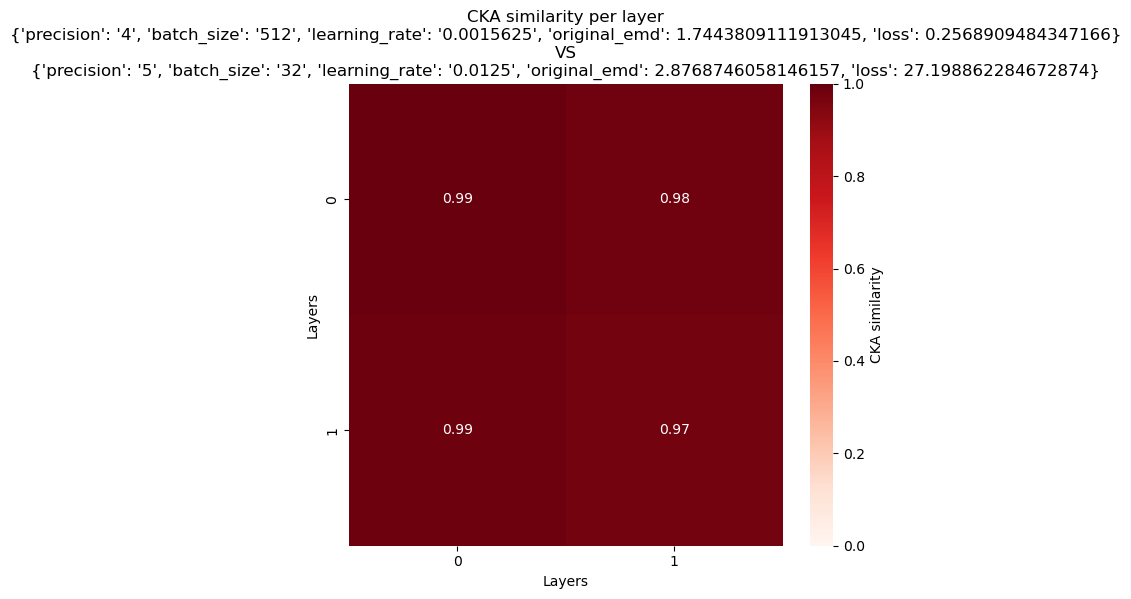

CUDA available!
Loading the result...
File baseline_bs16_lr0.025_p5_baseline_bs64_lr0.0125_p5.pkl not found!
Storing the result...
Complete
Distance: 0.009873628616333008


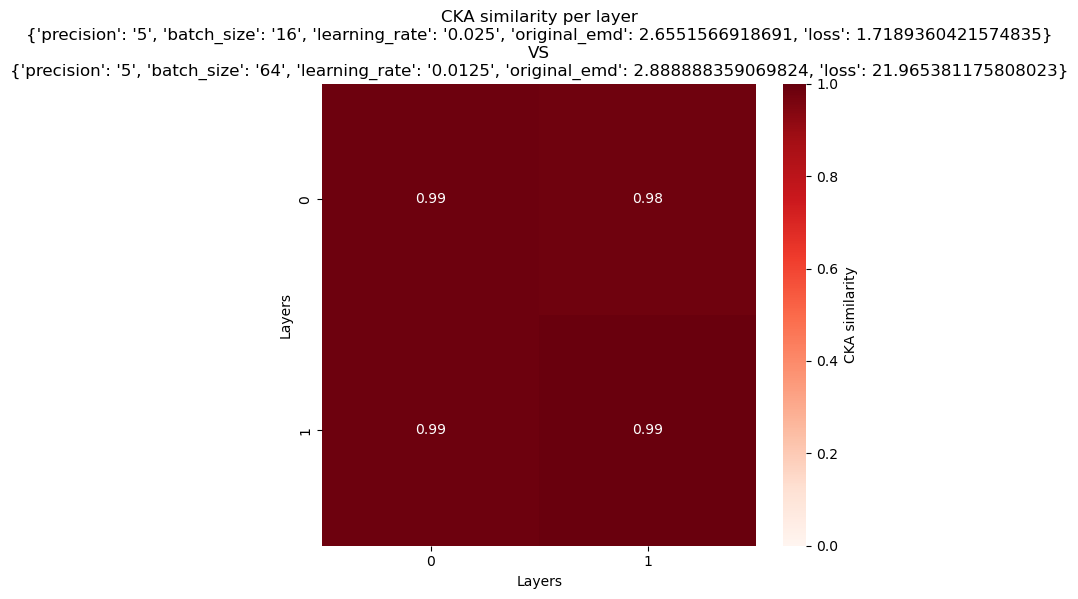

CUDA available!
Loading the result...
File baseline_bs128_lr0.0125_p5_baseline_bs512_lr0.0125_p3.pkl not found!
Storing the result...
Complete
Distance: 0.03069770336151123


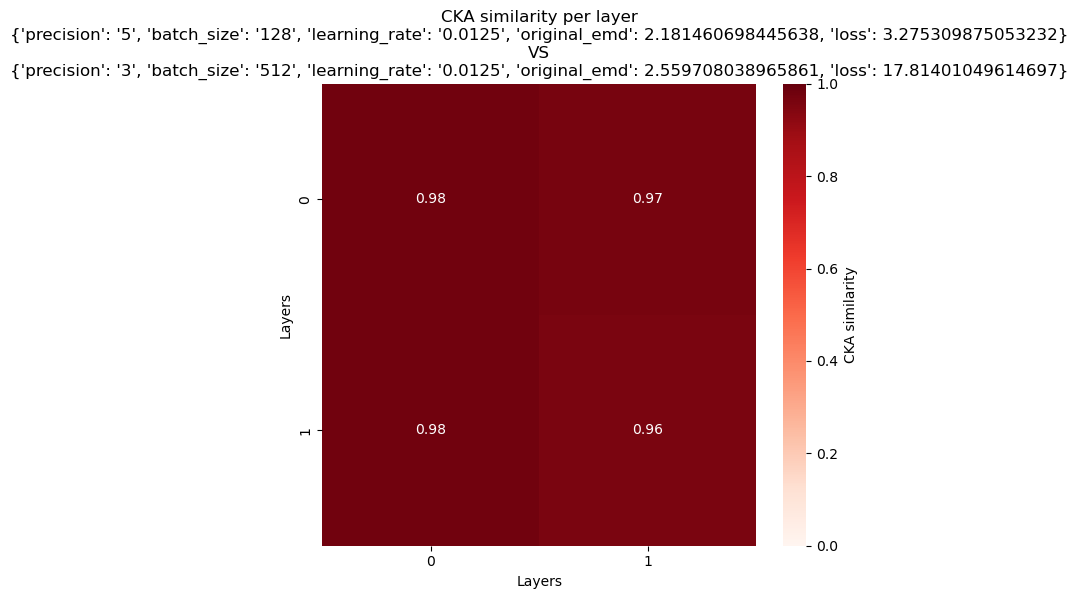

In [22]:
for i in range(3):
    worst_index = -(i+1)    # last in the ranking
    best_index = i

    cka = source_cka = get_cka_per_model(int(ranking_robust[best_index]['batch_size']),
                                         float(ranking_robust[best_index]['learning_rate']), 
                                         int(ranking_robust[best_index]['precision']),
                                         size,
                                         cka_dataloader,
                                         econ_layers,
                                         cka_batch_num)

    dist = compute_distance(cka,
                            int(ranking_robust[worst_index]['batch_size']),
                            float(ranking_robust[worst_index]['learning_rate']), 
                            int(ranking_robust[worst_index]['precision']),
                            size)

    print('Distance:', dist['cka_dist'])
    plot_2d_heatmap(dist['compared_cka'].cpu().detach().numpy(), 
                        f"CKA similarity per layer\n{ranking_robust[best_index]}\nVS\n{ranking_robust[worst_index]}", 
                        scale_label='CKA similarity')

### NOTE

## Compare average similarity among models
we compute the same distance many times in order to understand the number of batch sizes required to have a correct value for our analysis.

In [ ]:
cka = source_cka = get_cka_per_model(batch_sizes[top_models[0]['model'][0]],
                                        learning_rates[top_models[0]['model'][1]], 
                                        top_models[0]['precision'],
                                        size, 
                                        cka_datamodule.test_dataloader(),
                                        econ_layers,
                                        1)

values = []
for num_batches in range(50, 100):
    cka.max_batches = num_batches
    dist = compute_distance(cka,
                            batch_sizes[last_models[i]['model'][0]],
                            learning_rates[last_models[i]['model'][1]], 
                            last_models[i]['precision'],
                            size,
                            load=False)
    print(dist['cka_dist'])
    values.append(dist['cka_dist'])

CUDA available!


KeyboardInterrupt: 

In [ ]:
# perform dimensionality reduction (PCA or t-SNE)
embedding = PCA(n_components=2).fit_transform(distances_matrix)
# embedding = TSNE(n_components=2).fit_transform(distances)
# plot the scatter plot
plt.scatter(embedding[:, 0], embedding[:, 1])

# Annotate points with model index
for index, model in enumerate(top_models):
    plt.annotate(f'{index}', (embedding[index, 0], embedding[index, 1]))
    
plt.title('Model Distances')
plt.show()

NameError: name 'distances_matrix' is not defined

## Compare the real EMD without the flags of the empty matrix
During the studies of the loss landscape, we discover a strange case in the test of the ECON model. The Econ model is an autoencoder used to compress the information coming from signals that are encoded in a sort of matrix. To evaluate the model we should use the EMD but it is not differentiable, so it is used only as test and the training and evaluation of the model is done with an approximate EMD loss function called Telescope.

Looking at the models with big batch sizes (ex. 512 or 1024) we achieved negative EMD values during the test of the model, but it should not be possible (EMD >= 0). Looking at the implementation of the model we found in the computation of the real EMD thi flag, where if the output of the Encoder is zero set the emd as -0.5 which bias the final average EMD of the model, which in most of the case is actually really high.

<div style="text-align:center">
    <img src="images/EMD_flag.png"></img>
</div>



In [ ]:
def print_old_EMD(size, precision, bs, lr):
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    for exp in range(1, 3):
        file_path = base_path + f'bs{bs}_lr{lr}/ECON_{precision}b/{size}/{size}_emd_{exp}.txt'
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                print("AVG EMD: ", content)

        except Exception as e:
            continue


for lr in learning_rate:              
    print_old_EMD('small', 8, 1024, lr)

NameError: name 'learning_rate' is not defined

In [ ]:
trainer = pl.Trainer(
        max_epochs=5,
        accelerator="auto",
        devices=1
    )

def compute_real_EMD(size, precision, bs, lr):
    # load the model 
    model = load_model(base_path, bs, lr, precision, size)
    # get the data loader
    data_module = get_data_module(bs)
    _, val_sum = data_module.get_val_max_and_sum()
    model.set_val_sum(val_sum)
    data_module.setup("test")
    avg_emd = trainer.test(model, dataloaders=data_module.test_dataloader())
    print(f'BATCH SIZE: {bs} - LEARNING RATE {lr} - SIZE {size} - PRECISION {precision}')
    print("AVG EMD: ", avg_emd)
    


compute_real_EMD('small', 8, 1024, 0.1)
print_old_EMD('small', 8, 1024, 0.1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)
Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 341/341 [02:08<00:00,  2.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            13.577227592468262
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 13.577227592468262}]
BATCH SIZE: 1024 - LEARNING RATE 0.1 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': -0.19799108803272247}]
AVG EMD:  [{'AVG_EMD': -0.5}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.05)
print_old_EMD('small', 8, 1024, 0.05)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [02:26<00:00,  2.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD             9.190462112426758
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 9.190462112426758}]
BATCH SIZE: 1024 - LEARNING RATE 0.05 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 6.228666305541992}]
AVG EMD:  [{'AVG_EMD': 7.037817478179932}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0125)
print_old_EMD('small', 8, 1024, 0.0125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:28<00:00,  1.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.1153733730316162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153733730316162}]
BATCH SIZE: 1024 - LEARNING RATE 0.0125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.1153912544250488}]
AVG EMD:  [{'AVG_EMD': 1.1363208293914795}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.00625)
print_old_EMD('small', 8, 1024, 0.00625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:29<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2486552000045776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486552000045776}]
BATCH SIZE: 1024 - LEARNING RATE 0.00625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2486635446548462}]
AVG EMD:  [{'AVG_EMD': 1.254514455795288}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.003125)
print_old_EMD('small', 8, 1024, 0.003125)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:25<00:00,  1.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2884447574615479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2884447574615479}]
BATCH SIZE: 1024 - LEARNING RATE 0.003125 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2883154153823853}]
AVG EMD:  [{'AVG_EMD': 1.318579077720642}]


In [ ]:
compute_real_EMD('small', 8, 1024, 0.0015625)
print_old_EMD('small', 8, 1024, 0.0015625)

Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Reading files ['5Elinks_data.csv', 'nELinks5.npy']
Input data shape: (1740950, 48)


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepped shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data shape: (1740950, 1, 8, 8)
Loaded shaped data datatype: float32
Testing DataLoader 0: 100%|██████████| 341/341 [05:31<00:00,  1.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         AVG_EMD            1.2459907531738281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2459907531738281}]
BATCH SIZE: 1024 - LEARNING RATE 0.0015625 - SIZE small - PRECISION 8
AVG EMD:  [{'AVG_EMD': 1.2461320161819458}]
AVG EMD:  [{'AVG_EMD': 1.3005080223083496}]


As we can see from those results, negative values of EMD corresponds to really high values of EMD. I assume that when the model have to deal with large batch size and learning rates it has to process really big and sparse matrix which it just compress as Zero-matrices ignoring all the signals with low intensity. This could not be a problem since we are aware of it, especially because this event is not detected by the telescope loss function which returns good value of EMD. 